In [1]:
# pytorch mlp for binary classification
from numpy import vstack
from pandas import read_csv
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch import Tensor
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Sigmoid
from torch.nn import Module
from torch.optim import SGD
from torch.nn import BCELoss
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
df1 = pd.read_csv('../input/dataset1/predictive_maintenance.csv', delimiter=',')
df1.dataframeName = 'predictive_maintenance.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 10000 rows and 10 columns


In [3]:
df1.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [4]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB



**1. Apply the per-processing technics and the given dataset to clean,standardization/normalization of the data.**


In [5]:
# Check for missing values
df1.isnull().sum()


UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64

In [6]:
# Détecter les lignes dupliquées
duplicates = df1.duplicated()
print("Nombre de lignes dupliquées :", duplicates.sum())


Nombre de lignes dupliquées : 0


In [7]:
# Encode categorical variables
from sklearn.preprocessing import LabelEncoder

# Encode 'Type' and 'Failure Type'
label_encoder = LabelEncoder()
df1['Type'] = label_encoder.fit_transform(df1['Type'])
df1['Failure Type'] = label_encoder.fit_transform(df1['Failure Type'])


In [8]:
from sklearn.preprocessing import StandardScaler

# List of numerical columns to standardize
num_cols = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

# Standardize the numerical columns
scaler = StandardScaler()
df1[num_cols] = scaler.fit_transform(df1[num_cols])


In [9]:
# Drop the UDI column as it is an identifier
df1 = df1.drop(columns=['UDI','Product ID'],axis=1)
df1.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,2,-0.952389,-0.947360,0.068185,0.282200,-1.695984,0,1
1,1,-0.902393,-0.879959,-0.729472,0.633308,-1.648852,0,1
2,1,-0.952389,-1.014761,-0.227450,0.944290,-1.617430,0,1
3,1,-0.902393,-0.947360,-0.590021,-0.048845,-1.586009,0,1
4,1,-0.902393,-0.879959,-0.729472,0.001313,-1.554588,0,1


In [10]:
# Voir les valeurs uniques dans la colonne 'Type'
unique_types = df1['Target'].unique()
print("Valeurs uniques dans la colonne 'Type':", unique_types)


Valeurs uniques dans la colonne 'Type': [0 1]


**2. Apply the Exploratory data analysis technics to understand and visualize the given Dataset.**

In [11]:
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna(axis=1)
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

In [12]:

import matplotlib.pyplot as plt
import seaborn as sns

def plotCorrelationMatrix(df, graphWidth):
    # Check if the dataframe has a name attribute; otherwise, set a default name
    
    
    # Drop columns with NaN values and keep columns with more than one unique value
    df = df.dropna(axis=1)
    df = df[[col for col in df if df[col].nunique() > 1]]
    
    # Keep only numeric columns
    df = df.select_dtypes(include=[np.number])

    # If there are fewer than 2 numeric columns, exit
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant numeric columns ({df.shape[1]}) is less than 2')
        return

    # Calculate correlation matrix
    corr = df.corr()

    # Plot correlation matrix with annotations
    plt.figure(figsize=(graphWidth, graphWidth))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={'shrink': .8})
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.title(f'Correlation Matrix for', fontsize=15)
    plt.show()

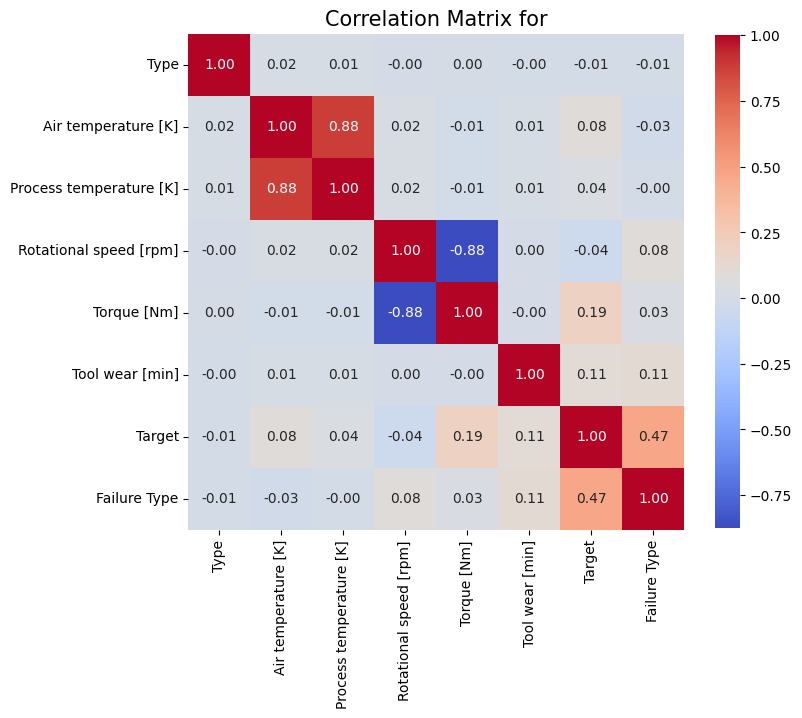

In [13]:
plotCorrelationMatrix(df1, 8)


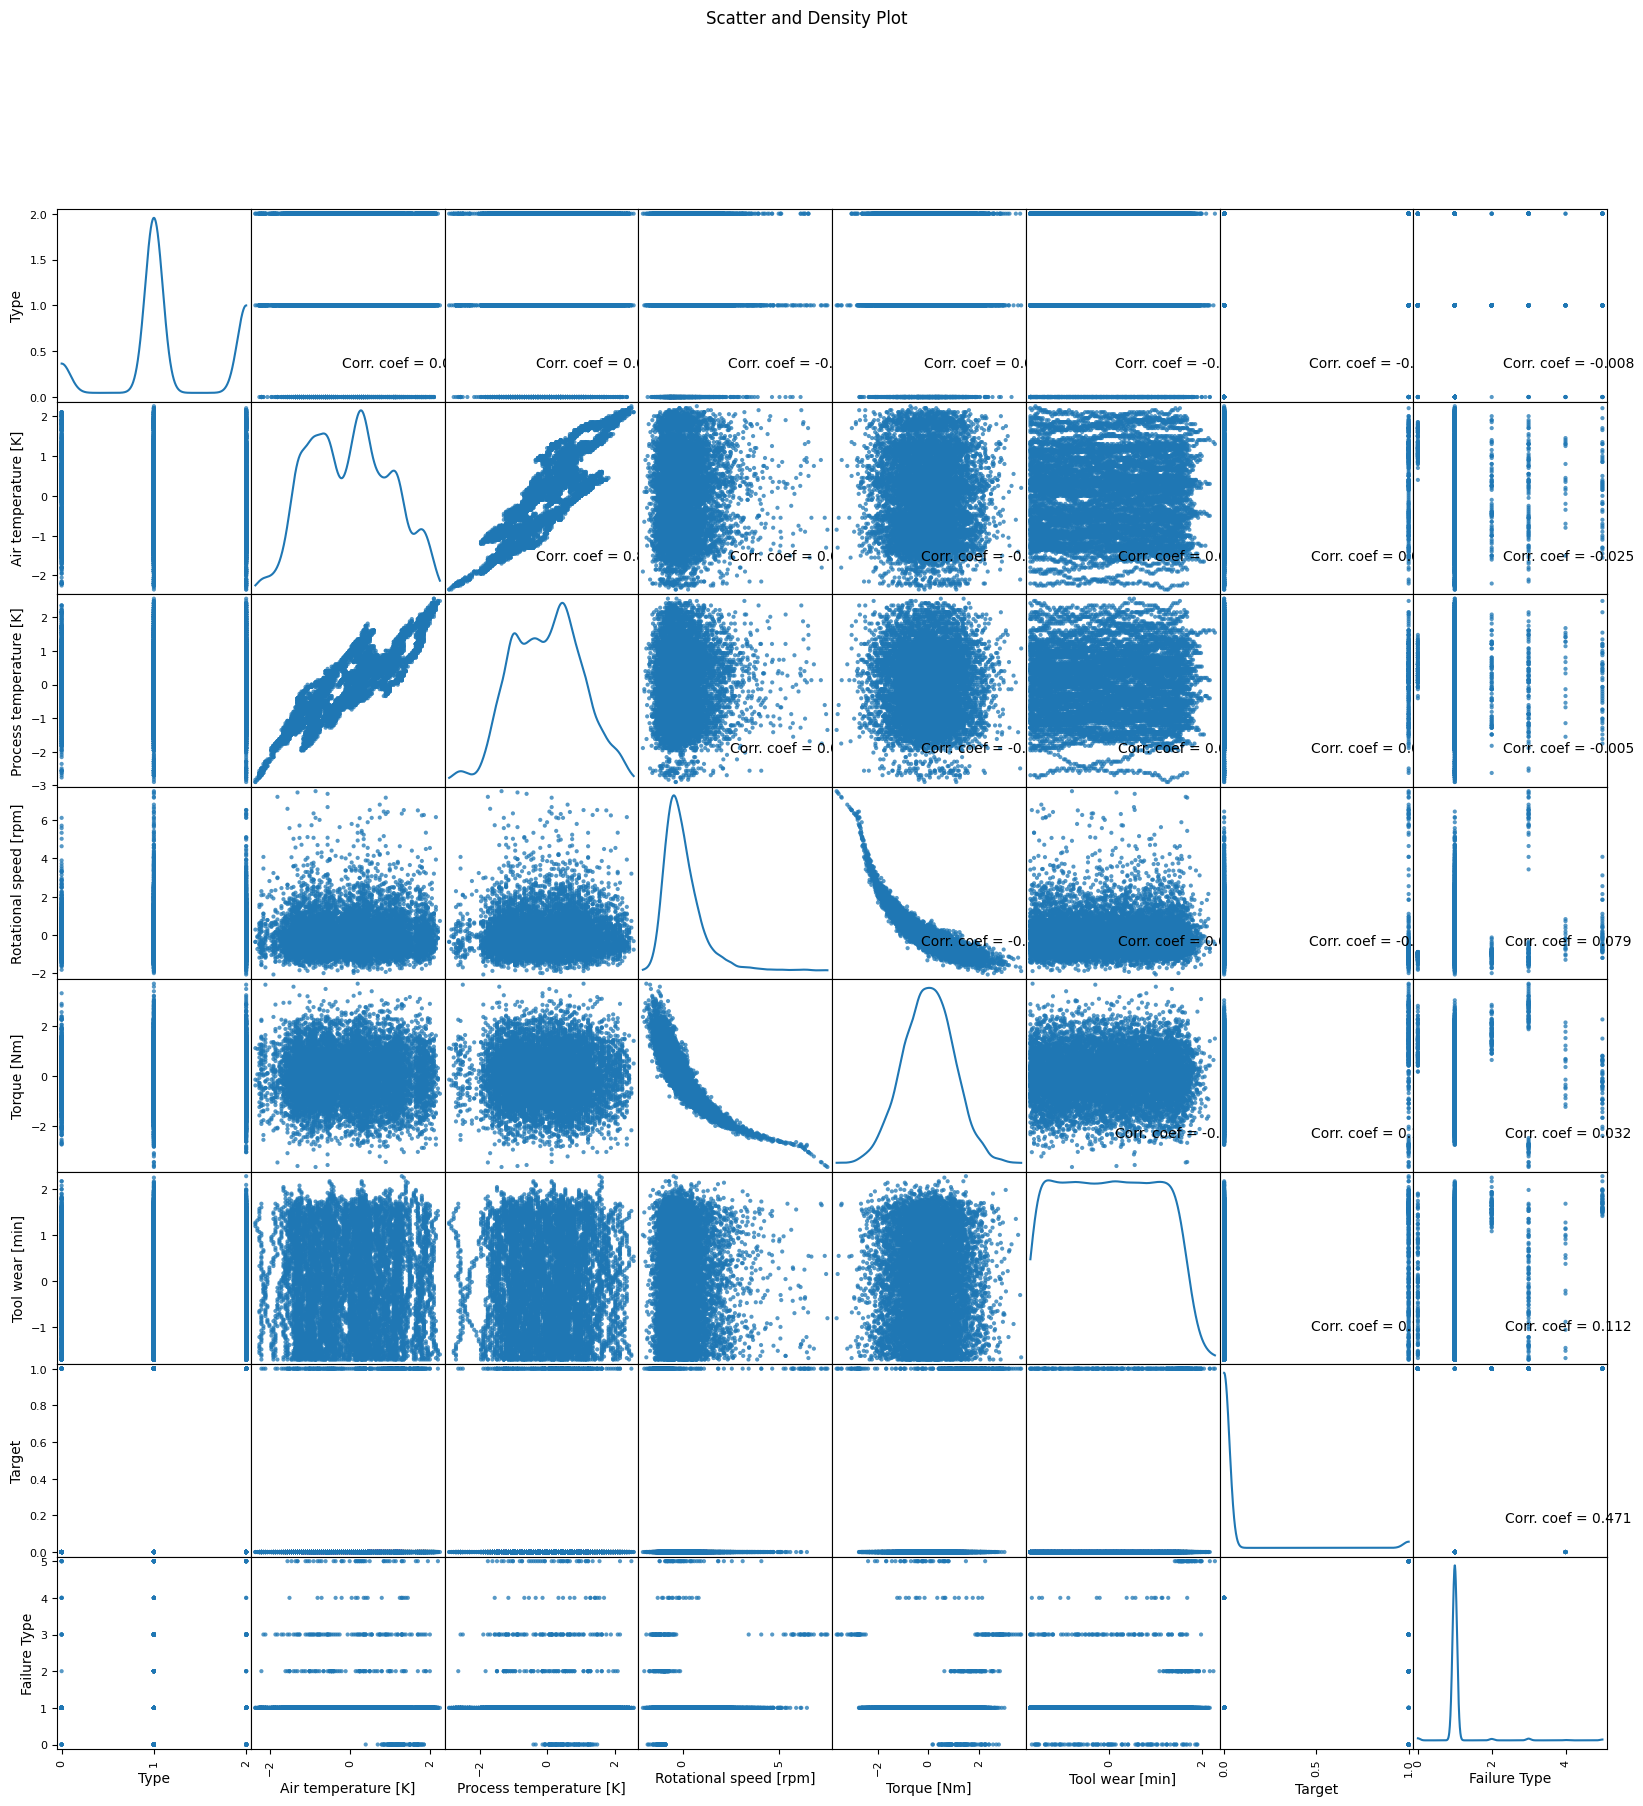

In [14]:
plotScatterMatrix(df1, 20, 10)


La majorité des colonnes montrent une faible corrélation entre elles, ce qui signifie que les variations de la plupart des variables n'ont que peu ou pas d'influence linéaire sur les autres. Cette faible corrélation suggère que les variables sont relativement indépendantes les unes des autres en termes de relation linéaire

**3. Apply data augmentation technics to balance the given Dataset.******

In [15]:
df1['Failure Type'].value_counts()


Failure Type
1    9652
0     112
3      95
2      78
5      45
4      18
Name: count, dtype: int64

On observe un déséquilibre dans les données, ce qui suggère la nécessité d'appliquer des techniques pour équilibrer le jeu de données."

In [16]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, RandomOverSampler

import pandas as pd

# Séparer les variables indépendantes (features) et la variable cible (Failure Type)
X = df1.drop('Failure Type', axis=1)  # Variables indépendantes
y = df1['Failure Type']  # Variable cible

# Diviser les données en ensemble d'entraînement et ensemble de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Appliquer SMOTE pour équilibrer l'ensemble d'entraînement
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

# Afficher la nouvelle distribution des classes après SMOTE
print("Avant SMOTE:")
print(y_train.value_counts())
print("\nAprès SMOTE:")
print(y_res.value_counts())



Avant SMOTE:
Failure Type
1    7717
0      97
3      75
2      65
5      34
4      12
Name: count, dtype: int64

Après SMOTE:
Failure Type
1    7717
3    7717
0    7717
5    7717
2    7717
4    7717
Name: count, dtype: int64


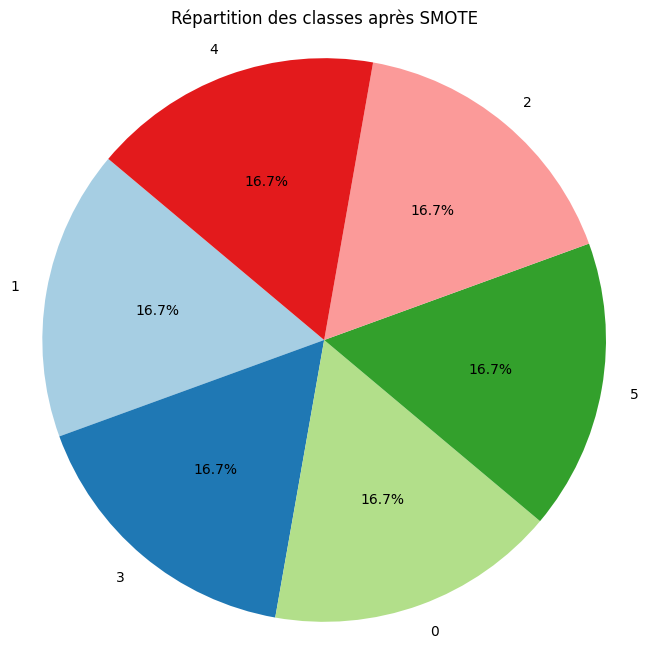

In [17]:
import matplotlib.pyplot as plt

# Calculer les pourcentages de chaque classe après SMOTE
class_percentage = y_res.value_counts(normalize=True) * 100

# Créer un graphique à secteurs pour afficher les pourcentages
plt.figure(figsize=(8, 8))
plt.pie(class_percentage, labels=class_percentage.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Répartition des classes après SMOTE')
plt.axis('equal')  # Pour un cercle parfait
plt.show()



**4. Establish a Deep Neural network Architecture by using PyTorch library to handle the multiclass classification task.**


In [18]:
# model definition with more neurons
class MLP(Module):
    def __init__(self, n_inputs, n_outputs):
        super(MLP, self).__init__()
        # input to first hidden layer (increased to 32 neurons)
        self.hidden1 = Linear(n_inputs, 32)
        kaiming_uniform_(self.hidden1.weight, nonlinearity='relu')
        self.act1 = ReLU()
        self.dropout1 = Dropout(0.2)
        # second hidden layer (increased to 64 neurons)
        self.hidden2 = Linear(32, 64)
        kaiming_uniform_(self.hidden2.weight, nonlinearity='relu')
        self.act2 = ReLU()
        self.dropout2 = Dropout(0.2)
        # third hidden layer (increased to 32 neurons)
        self.hidden3 = Linear(64, 32)
        kaiming_uniform_(self.hidden3.weight, nonlinearity='relu')
        self.act3 = ReLU()
        # output layer
        self.hidden4 = Linear(32, n_outputs)
        xavier_uniform_(self.hidden4.weight)
        self.act4 = Softmax(dim=1)

    def forward(self, X):
        X = self.hidden1(X)
        X = self.act1(X)
        X = self.dropout1(X)
        X = self.hidden2(X)
        X = self.act2(X)
        X = self.dropout2(X)
        X = self.hidden3(X)
        X = self.act3(X)
        X = self.hidden4(X)
        X = self.act4(X)
        return X


In [19]:
###### from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import MSELoss
from torch.optim import SGD
from tqdm import tqdm
import torch

# Utiliser scikit-learn pour préparer les données
def prepare_data_sklearn(X, y, test_size=0.2, batch_size=32):
    # Diviser les données en train et test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    # Convertir les DataFrames en tensors PyTorch
    X_train, X_test = torch.tensor(X_train.values,dtype=torch.float64), torch.tensor(X_test.values,dtype=torch.float64)
    y_train, y_test = torch.tensor(y_train.values,dtype=torch.int64), torch.tensor(y_test.values,dtype=torch.int64)
    
    # Créer des TensorDataset
    train_ds = TensorDataset(X_train, y_train)
    test_ds = TensorDataset(X_test, y_test)
    
    # Créer des DataLoader pour PyTorch
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
    
    return train_dl, test_dl




In [20]:
import numpy as np
import torch

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn

def train_model(train_dl, test_dl, model):
    patience = 7
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=0.01, weight_decay=0.01)
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    loss_per_epoch = []
    loss_per_epoch_validation = []
    accuracy_per_epoch_train = []  # Liste pour stocker l'accuracy de l'entraînement
    accuracy_per_epoch_valid = []  # Liste pour stocker l'accuracy de la validation
    
    for epoch in tqdm(range(500), desc="Training Epochs"):
        print(f"Epoch {epoch+1}\n-------------------------------")
        model.train()
        TrainingStep_loss = []

        for batch, (inputs, targets) in enumerate(train_dl):
            inputs = inputs.float()
            targets = targets.long()

            optimizer.zero_grad()
            yhat = model(inputs)
            loss = criterion(yhat, targets)
            loss.backward()
            optimizer.step()
            TrainingStep_loss.append(loss.item())

        train_loss = np.mean(TrainingStep_loss)
        loss_per_epoch.append(train_loss)
        print(f"Training Loss: {train_loss:.6f}")

        # Calculer l'accuracy d'entraînement
        train_accuracy = evaluate_model(train_dl, model)
        accuracy_per_epoch_train.append(train_accuracy)  # Stocker l'accuracy d'entraînement
        print(f"Training Accuracy: {train_accuracy:.6f}")

        # Validation
        model.eval()
        validationStep_loss = []

        with torch.no_grad():
            for batch, (inputs, targets) in enumerate(test_dl):
                inputs = inputs.float()
                targets = targets.long()
                outputs = model(inputs)
                validation_loss = criterion(outputs, targets)
                validationStep_loss.append(validation_loss.item())

        valid_loss = np.mean(validationStep_loss)
        loss_per_epoch_validation.append(valid_loss)
        print(f"Validation Loss: {valid_loss:.6f}")

        # Calculer l'accuracy de validation
        valid_accuracy = evaluate_model(test_dl, model)
        accuracy_per_epoch_valid.append(valid_accuracy)  # Stocker l'accuracy de validation
        print(f"Validation Accuracy: {valid_accuracy:.6f}")

        # Early stopping logic
        early_stopping(valid_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    # Retourner les valeurs pour les tracer
    return loss_per_epoch, loss_per_epoch_validation, accuracy_per_epoch_train, accuracy_per_epoch_valid




       
# Après l'entraînement, tracer les courbes
def plot_loss_and_accuracy(loss_train, loss_validation, acc_train, acc_validation):
    epochs = range(1, len(loss_train) + 1)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

    # Tracer la courbe de la perte
    ax1.plot(epochs, loss_train, label="Training Loss", color="b")
    ax1.plot(epochs, loss_validation, label="Validation Loss", color="r")
    ax1.set_title("Training and Validation Loss per Epoch")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend()
    ax1.grid(True)

    # Tracer la courbe de l'accuracy
    ax2.plot(epochs, acc_train, label="Training Accuracy", color="g")
    ax2.plot(epochs, acc_validation, label="Validation Accuracy", color="orange")
    ax2.set_title("Training and Validation Accuracy per Epoch")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()




In [22]:
# evaluate the model
def evaluate_model(data_loader, model):
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.float()
            targets = targets.long()
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    accuracy = correct / total
    return accuracy


8000 2000


Training Epochs:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1
-------------------------------
Training Loss: 1.094998


Training Epochs:   0%|          | 1/500 [00:01<08:48,  1.06s/it]

Training Accuracy: 0.964625
Validation Loss: 1.080392
Validation Accuracy: 0.967500
Validation loss decreased (inf --> 1.080392).  Saving model ...
Epoch 2
-------------------------------
Training Loss: 1.082891


Training Epochs:   0%|          | 2/500 [00:01<07:53,  1.05it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079423
Validation Accuracy: 0.967500
Validation loss decreased (1.080392 --> 1.079423).  Saving model ...
Epoch 3
-------------------------------
Training Loss: 1.082880


Training Epochs:   1%|          | 3/500 [00:02<07:34,  1.09it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079622
Validation Accuracy: 0.967500
EarlyStopping counter: 1 out of 7
Epoch 4
-------------------------------
Training Loss: 1.082874


Training Epochs:   1%|          | 4/500 [00:03<07:22,  1.12it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079309
Validation Accuracy: 0.967500
Validation loss decreased (1.079423 --> 1.079309).  Saving model ...
Epoch 5
-------------------------------
Training Loss: 1.082872


Training Epochs:   1%|          | 5/500 [00:04<07:12,  1.15it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079551
Validation Accuracy: 0.967500
EarlyStopping counter: 1 out of 7
Epoch 6
-------------------------------
Training Loss: 1.082916


Training Epochs:   1%|          | 6/500 [00:05<07:05,  1.16it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078815
Validation Accuracy: 0.967500
Validation loss decreased (1.079309 --> 1.078815).  Saving model ...
Epoch 7
-------------------------------
Training Loss: 1.082898


Training Epochs:   1%|▏         | 7/500 [00:06<07:05,  1.16it/s]

Training Accuracy: 0.964625
Validation Loss: 1.081213
Validation Accuracy: 0.967500
EarlyStopping counter: 1 out of 7
Epoch 8
-------------------------------
Training Loss: 1.082903


Training Epochs:   2%|▏         | 8/500 [00:07<07:06,  1.15it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078490
Validation Accuracy: 0.967500
Validation loss decreased (1.078815 --> 1.078490).  Saving model ...
Epoch 9
-------------------------------
Training Loss: 1.082894


Training Epochs:   2%|▏         | 9/500 [00:07<07:10,  1.14it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079960
Validation Accuracy: 0.967500
EarlyStopping counter: 1 out of 7
Epoch 10
-------------------------------
Training Loss: 1.082929


Training Epochs:   2%|▏         | 10/500 [00:08<07:07,  1.15it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078729
Validation Accuracy: 0.967500
EarlyStopping counter: 2 out of 7
Epoch 11
-------------------------------
Training Loss: 1.082887


Training Epochs:   2%|▏         | 11/500 [00:09<07:04,  1.15it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079841
Validation Accuracy: 0.967500
EarlyStopping counter: 3 out of 7
Epoch 12
-------------------------------
Training Loss: 1.082914


Training Epochs:   2%|▏         | 12/500 [00:10<07:03,  1.15it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080127
Validation Accuracy: 0.967500
EarlyStopping counter: 4 out of 7
Epoch 13
-------------------------------
Training Loss: 1.082928


Training Epochs:   3%|▎         | 13/500 [00:11<07:02,  1.15it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079827
Validation Accuracy: 0.967500
EarlyStopping counter: 5 out of 7
Epoch 14
-------------------------------
Training Loss: 1.082896


Training Epochs:   3%|▎         | 14/500 [00:12<07:00,  1.16it/s]

Training Accuracy: 0.964625
Validation Loss: 1.081628
Validation Accuracy: 0.967500
EarlyStopping counter: 6 out of 7
Epoch 15
-------------------------------
Training Loss: 1.082922


Training Epochs:   3%|▎         | 15/500 [00:13<06:59,  1.16it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078069
Validation Accuracy: 0.967500
Validation loss decreased (1.078490 --> 1.078069).  Saving model ...
Epoch 16
-------------------------------
Training Loss: 1.082925


Training Epochs:   3%|▎         | 16/500 [00:14<06:55,  1.16it/s]

Training Accuracy: 0.964625
Validation Loss: 1.082425
Validation Accuracy: 0.967500
EarlyStopping counter: 1 out of 7
Epoch 17
-------------------------------
Training Loss: 1.082934


Training Epochs:   3%|▎         | 17/500 [00:14<07:02,  1.14it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079137
Validation Accuracy: 0.967500
EarlyStopping counter: 2 out of 7
Epoch 18
-------------------------------
Training Loss: 1.082948


Training Epochs:   4%|▎         | 18/500 [00:15<07:15,  1.11it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078792
Validation Accuracy: 0.967500
EarlyStopping counter: 3 out of 7
Epoch 19
-------------------------------
Training Loss: 1.082912


Training Epochs:   4%|▍         | 19/500 [00:16<07:29,  1.07it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078991
Validation Accuracy: 0.967500
EarlyStopping counter: 4 out of 7
Epoch 20
-------------------------------
Training Loss: 1.082894


Training Epochs:   4%|▍         | 20/500 [00:17<07:37,  1.05it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079366
Validation Accuracy: 0.967500
EarlyStopping counter: 5 out of 7
Epoch 21
-------------------------------
Training Loss: 1.082922


Training Epochs:   4%|▍         | 21/500 [00:18<07:40,  1.04it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078437
Validation Accuracy: 0.967500
EarlyStopping counter: 6 out of 7
Epoch 22
-------------------------------
Training Loss: 1.082921


Training Epochs:   4%|▍         | 21/500 [00:19<07:32,  1.06it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080496
Validation Accuracy: 0.967500
EarlyStopping counter: 7 out of 7
Early stopping


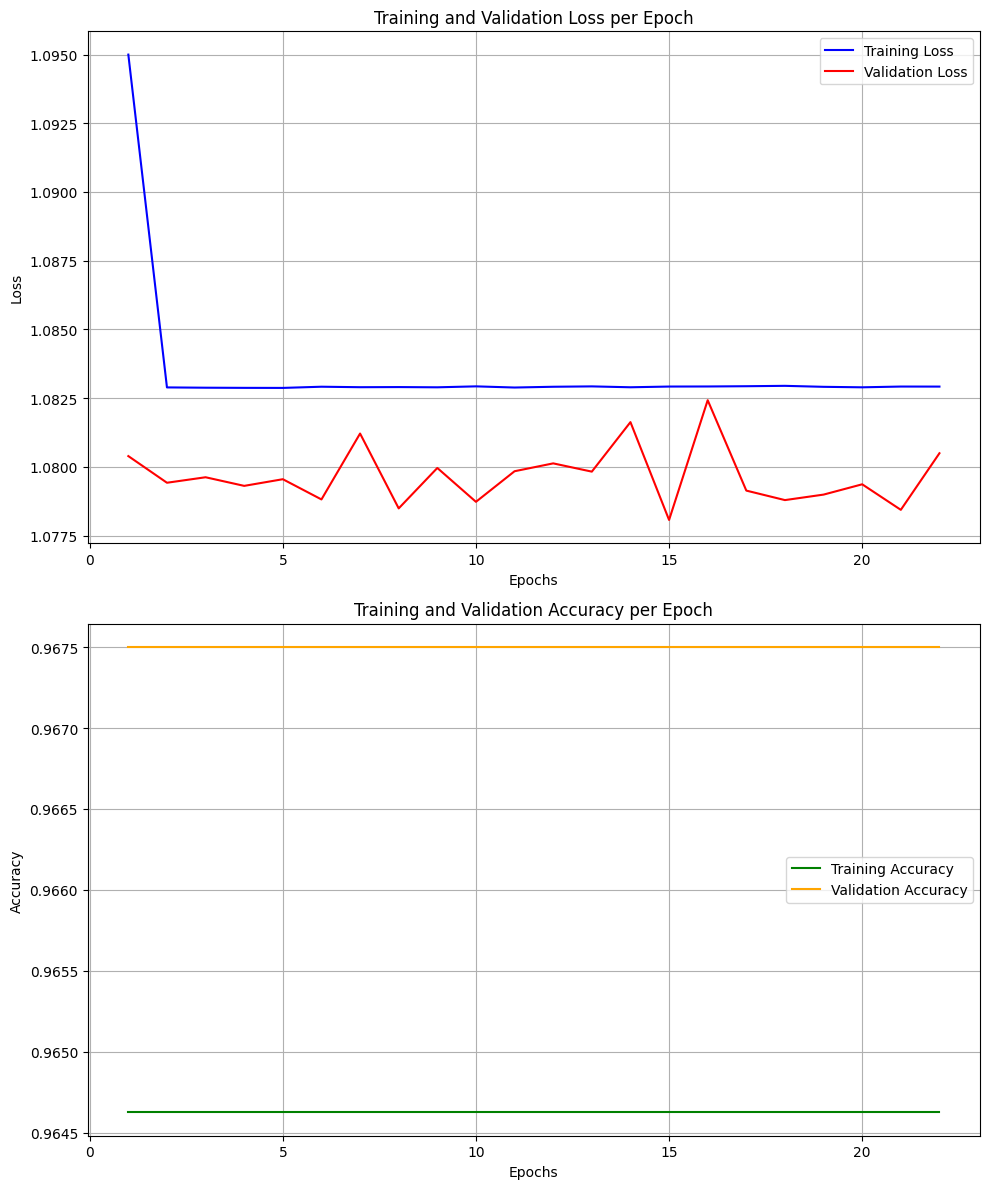

In [23]:
# pytorch mlp for multiclass classification
from numpy import vstack
from numpy import argmax
from pandas import read_csv
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from torch import Tensor
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Softmax
from torch.nn import Module
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_
from tqdm import tqdm
from torch.nn import Dropout

train_dl, test_dl = prepare_data_sklearn(X,y)
print(len(train_dl.dataset), len(test_dl.dataset))
# define the network
model = MLP(7,6)
# train the model
# train the model
loss_per_epoch, loss_per_epoch_validation, accuracy_per_epoch_train, accuracy_per_epoch_valid = train_model(train_dl, test_dl, model)

# Tracer la perte et l'accuracy (vous devez passer aussi les listes d'accuracy)
plot_loss_and_accuracy(loss_per_epoch, loss_per_epoch_validation, accuracy_per_epoch_train, accuracy_per_epoch_valid)


****with out using earlystopping ****

Training Epochs:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1
-------------------------------
Training Loss: 1.089268


Training Epochs:   0%|          | 1/500 [00:00<07:20,  1.13it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079436
Validation Accuracy: 0.967500
Epoch 2
-------------------------------
Training Loss: 1.082912


Training Epochs:   0%|          | 2/500 [00:01<07:17,  1.14it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079329
Validation Accuracy: 0.967500
Epoch 3
-------------------------------
Training Loss: 1.082855


Training Epochs:   1%|          | 3/500 [00:02<07:11,  1.15it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080829
Validation Accuracy: 0.967500
Epoch 4
-------------------------------
Training Loss: 1.082927


Training Epochs:   1%|          | 4/500 [00:03<07:06,  1.16it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079706
Validation Accuracy: 0.967500
Epoch 5
-------------------------------
Training Loss: 1.082877


Training Epochs:   1%|          | 5/500 [00:04<07:17,  1.13it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080998
Validation Accuracy: 0.967500
Epoch 6
-------------------------------
Training Loss: 1.082903


Training Epochs:   1%|          | 6/500 [00:05<08:03,  1.02it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079431
Validation Accuracy: 0.967500
Epoch 7
-------------------------------
Training Loss: 1.082893


Training Epochs:   1%|▏         | 7/500 [00:06<08:13,  1.00s/it]

Training Accuracy: 0.964625
Validation Loss: 1.078984
Validation Accuracy: 0.967500
Epoch 8
-------------------------------
Training Loss: 1.082889


Training Epochs:   2%|▏         | 8/500 [00:07<07:57,  1.03it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080480
Validation Accuracy: 0.967500
Epoch 9
-------------------------------
Training Loss: 1.082893


Training Epochs:   2%|▏         | 9/500 [00:08<07:44,  1.06it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079970
Validation Accuracy: 0.967500
Epoch 10
-------------------------------
Training Loss: 1.082906


Training Epochs:   2%|▏         | 10/500 [00:09<07:31,  1.09it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079348
Validation Accuracy: 0.967500
Epoch 11
-------------------------------
Training Loss: 1.082935


Training Epochs:   2%|▏         | 11/500 [00:10<07:20,  1.11it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079693
Validation Accuracy: 0.967500
Epoch 12
-------------------------------
Training Loss: 1.082908


Training Epochs:   2%|▏         | 12/500 [00:10<07:15,  1.12it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080860
Validation Accuracy: 0.967500
Epoch 13
-------------------------------
Training Loss: 1.082904


Training Epochs:   3%|▎         | 13/500 [00:11<07:11,  1.13it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079195
Validation Accuracy: 0.967500
Epoch 14
-------------------------------
Training Loss: 1.082925


Training Epochs:   3%|▎         | 14/500 [00:12<07:14,  1.12it/s]

Training Accuracy: 0.964625
Validation Loss: 1.081402
Validation Accuracy: 0.967500
Epoch 15
-------------------------------
Training Loss: 1.082913


Training Epochs:   3%|▎         | 15/500 [00:13<07:12,  1.12it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078880
Validation Accuracy: 0.967500
Epoch 16
-------------------------------
Training Loss: 1.082924


Training Epochs:   3%|▎         | 16/500 [00:14<07:09,  1.13it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080836
Validation Accuracy: 0.967500
Epoch 17
-------------------------------
Training Loss: 1.082936


Training Epochs:   3%|▎         | 17/500 [00:15<07:06,  1.13it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079483
Validation Accuracy: 0.967500
Epoch 18
-------------------------------
Training Loss: 1.082888


Training Epochs:   4%|▎         | 18/500 [00:16<07:15,  1.11it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080724
Validation Accuracy: 0.967500
Epoch 19
-------------------------------
Training Loss: 1.082934


Training Epochs:   4%|▍         | 19/500 [00:17<07:23,  1.08it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080459
Validation Accuracy: 0.967500
Epoch 20
-------------------------------
Training Loss: 1.082903


Training Epochs:   4%|▍         | 20/500 [00:18<07:31,  1.06it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078677
Validation Accuracy: 0.967500
Epoch 21
-------------------------------
Training Loss: 1.082910


Training Epochs:   4%|▍         | 21/500 [00:19<07:42,  1.04it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078355
Validation Accuracy: 0.967500
Epoch 22
-------------------------------
Training Loss: 1.082878


Training Epochs:   4%|▍         | 22/500 [00:20<07:35,  1.05it/s]

Training Accuracy: 0.964625
Validation Loss: 1.081672
Validation Accuracy: 0.967500
Epoch 23
-------------------------------
Training Loss: 1.082922


Training Epochs:   5%|▍         | 23/500 [00:21<07:31,  1.06it/s]

Training Accuracy: 0.964625
Validation Loss: 1.081134
Validation Accuracy: 0.967500
Epoch 24
-------------------------------
Training Loss: 1.082944


Training Epochs:   5%|▍         | 24/500 [00:22<07:28,  1.06it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079754
Validation Accuracy: 0.967500
Epoch 25
-------------------------------
Training Loss: 1.082922


Training Epochs:   5%|▌         | 25/500 [00:23<07:21,  1.08it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079715
Validation Accuracy: 0.967500
Epoch 26
-------------------------------
Training Loss: 1.082946


Training Epochs:   5%|▌         | 26/500 [00:23<07:20,  1.08it/s]

Training Accuracy: 0.964625
Validation Loss: 1.081303
Validation Accuracy: 0.967500
Epoch 27
-------------------------------
Training Loss: 1.082923


Training Epochs:   5%|▌         | 27/500 [00:24<07:25,  1.06it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079126
Validation Accuracy: 0.967500
Epoch 28
-------------------------------
Training Loss: 1.082914


Training Epochs:   6%|▌         | 28/500 [00:25<07:38,  1.03it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079763
Validation Accuracy: 0.967500
Epoch 29
-------------------------------
Training Loss: 1.082934


Training Epochs:   6%|▌         | 29/500 [00:27<07:52,  1.00s/it]

Training Accuracy: 0.964625
Validation Loss: 1.079829
Validation Accuracy: 0.967500
Epoch 30
-------------------------------
Training Loss: 1.082931


Training Epochs:   6%|▌         | 30/500 [00:28<07:46,  1.01it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078111
Validation Accuracy: 0.967500
Epoch 31
-------------------------------
Training Loss: 1.082906


Training Epochs:   6%|▌         | 31/500 [00:28<07:40,  1.02it/s]

Training Accuracy: 0.964625
Validation Loss: 1.081837
Validation Accuracy: 0.967500
Epoch 32
-------------------------------
Training Loss: 1.082917


Training Epochs:   6%|▋         | 32/500 [00:29<07:40,  1.02it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078682
Validation Accuracy: 0.967500
Epoch 33
-------------------------------
Training Loss: 1.082914


Training Epochs:   7%|▋         | 33/500 [00:30<07:42,  1.01it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079578
Validation Accuracy: 0.967500
Epoch 34
-------------------------------
Training Loss: 1.082915


Training Epochs:   7%|▋         | 34/500 [00:31<07:36,  1.02it/s]

Training Accuracy: 0.964625
Validation Loss: 1.077511
Validation Accuracy: 0.967500
Epoch 35
-------------------------------
Training Loss: 1.082897


Training Epochs:   7%|▋         | 35/500 [00:32<07:30,  1.03it/s]

Training Accuracy: 0.964625
Validation Loss: 1.081781
Validation Accuracy: 0.967500
Epoch 36
-------------------------------
Training Loss: 1.082938


Training Epochs:   7%|▋         | 36/500 [00:33<07:28,  1.04it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080459
Validation Accuracy: 0.967500
Epoch 37
-------------------------------
Training Loss: 1.082893


Training Epochs:   7%|▋         | 37/500 [00:34<07:26,  1.04it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079054
Validation Accuracy: 0.967500
Epoch 38
-------------------------------
Training Loss: 1.082910


Training Epochs:   8%|▊         | 38/500 [00:35<07:21,  1.05it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078757
Validation Accuracy: 0.967500
Epoch 39
-------------------------------
Training Loss: 1.082907


Training Epochs:   8%|▊         | 39/500 [00:36<07:37,  1.01it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079271
Validation Accuracy: 0.967500
Epoch 40
-------------------------------
Training Loss: 1.082921


Training Epochs:   8%|▊         | 40/500 [00:37<08:00,  1.04s/it]

Training Accuracy: 0.964625
Validation Loss: 1.079275
Validation Accuracy: 0.967500
Epoch 41
-------------------------------
Training Loss: 1.082897


Training Epochs:   8%|▊         | 41/500 [00:38<07:53,  1.03s/it]

Training Accuracy: 0.964625
Validation Loss: 1.079141
Validation Accuracy: 0.967500
Epoch 42
-------------------------------
Training Loss: 1.082877
Training Accuracy: 0.964625


Training Epochs:   8%|▊         | 42/500 [00:39<07:25,  1.03it/s]

Validation Loss: 1.081211
Validation Accuracy: 0.967500
Epoch 43
-------------------------------
Training Loss: 1.082943


Training Epochs:   9%|▊         | 43/500 [00:40<07:00,  1.09it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078794
Validation Accuracy: 0.967500
Epoch 44
-------------------------------
Training Loss: 1.082903


Training Epochs:   9%|▉         | 44/500 [00:41<06:47,  1.12it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078181
Validation Accuracy: 0.967500
Epoch 45
-------------------------------
Training Loss: 1.082884


Training Epochs:   9%|▉         | 45/500 [00:42<06:42,  1.13it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079639
Validation Accuracy: 0.967500
Epoch 46
-------------------------------
Training Loss: 1.082906


Training Epochs:   9%|▉         | 46/500 [00:43<06:37,  1.14it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079902
Validation Accuracy: 0.967500
Epoch 47
-------------------------------
Training Loss: 1.082944


Training Epochs:   9%|▉         | 47/500 [00:43<06:28,  1.16it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078680
Validation Accuracy: 0.967500
Epoch 48
-------------------------------
Training Loss: 1.082918
Training Accuracy: 0.964625


Training Epochs:  10%|▉         | 48/500 [00:44<06:21,  1.18it/s]

Validation Loss: 1.078961
Validation Accuracy: 0.967500
Epoch 49
-------------------------------
Training Loss: 1.082901


Training Epochs:  10%|▉         | 49/500 [00:45<06:16,  1.20it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080779
Validation Accuracy: 0.967500
Epoch 50
-------------------------------
Training Loss: 1.082898
Training Accuracy: 0.964625


Training Epochs:  10%|█         | 50/500 [00:46<06:17,  1.19it/s]

Validation Loss: 1.080556
Validation Accuracy: 0.967500
Epoch 51
-------------------------------
Training Loss: 1.082908


Training Epochs:  10%|█         | 51/500 [00:47<06:20,  1.18it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079468
Validation Accuracy: 0.967500
Epoch 52
-------------------------------
Training Loss: 1.082907
Training Accuracy: 0.964625


Training Epochs:  10%|█         | 52/500 [00:48<06:16,  1.19it/s]

Validation Loss: 1.083030
Validation Accuracy: 0.967500
Epoch 53
-------------------------------
Training Loss: 1.082927


Training Epochs:  11%|█         | 53/500 [00:48<06:15,  1.19it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080443
Validation Accuracy: 0.967500
Epoch 54
-------------------------------
Training Loss: 1.082911


Training Epochs:  11%|█         | 54/500 [00:49<06:15,  1.19it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079104
Validation Accuracy: 0.967500
Epoch 55
-------------------------------
Training Loss: 1.082903


Training Epochs:  11%|█         | 55/500 [00:50<06:10,  1.20it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079061
Validation Accuracy: 0.967500
Epoch 56
-------------------------------
Training Loss: 1.082897


Training Epochs:  11%|█         | 56/500 [00:51<06:09,  1.20it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078604
Validation Accuracy: 0.967500
Epoch 57
-------------------------------
Training Loss: 1.082916
Training Accuracy: 0.964625


Training Epochs:  11%|█▏        | 57/500 [00:52<06:07,  1.21it/s]

Validation Loss: 1.078330
Validation Accuracy: 0.967500
Epoch 58
-------------------------------
Training Loss: 1.082923


Training Epochs:  12%|█▏        | 58/500 [00:53<06:07,  1.20it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080348
Validation Accuracy: 0.967500
Epoch 59
-------------------------------
Training Loss: 1.082929


Training Epochs:  12%|█▏        | 59/500 [00:53<06:08,  1.20it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078979
Validation Accuracy: 0.967500
Epoch 60
-------------------------------
Training Loss: 1.082887


Training Epochs:  12%|█▏        | 60/500 [00:54<06:07,  1.20it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078345
Validation Accuracy: 0.967500
Epoch 61
-------------------------------
Training Loss: 1.082920


Training Epochs:  12%|█▏        | 61/500 [00:55<06:05,  1.20it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079678
Validation Accuracy: 0.967500
Epoch 62
-------------------------------
Training Loss: 1.082904


Training Epochs:  12%|█▏        | 62/500 [00:56<06:06,  1.19it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080256
Validation Accuracy: 0.967500
Epoch 63
-------------------------------
Training Loss: 1.082899


Training Epochs:  13%|█▎        | 63/500 [00:57<06:16,  1.16it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080059
Validation Accuracy: 0.967500
Epoch 64
-------------------------------
Training Loss: 1.082960


Training Epochs:  13%|█▎        | 64/500 [00:58<06:23,  1.14it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078991
Validation Accuracy: 0.967500
Epoch 65
-------------------------------
Training Loss: 1.082895


Training Epochs:  13%|█▎        | 65/500 [00:59<06:30,  1.11it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079262
Validation Accuracy: 0.967500
Epoch 66
-------------------------------
Training Loss: 1.082879


Training Epochs:  13%|█▎        | 66/500 [01:00<06:29,  1.11it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079420
Validation Accuracy: 0.967500
Epoch 67
-------------------------------
Training Loss: 1.082916


Training Epochs:  13%|█▎        | 67/500 [01:01<06:29,  1.11it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078673
Validation Accuracy: 0.967500
Epoch 68
-------------------------------
Training Loss: 1.082943


Training Epochs:  14%|█▎        | 68/500 [01:01<06:30,  1.11it/s]

Training Accuracy: 0.964625
Validation Loss: 1.077610
Validation Accuracy: 0.967500
Epoch 69
-------------------------------
Training Loss: 1.082915


Training Epochs:  14%|█▍        | 69/500 [01:02<06:28,  1.11it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079401
Validation Accuracy: 0.967500
Epoch 70
-------------------------------
Training Loss: 1.082922


Training Epochs:  14%|█▍        | 70/500 [01:03<06:28,  1.11it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078871
Validation Accuracy: 0.967500
Epoch 71
-------------------------------
Training Loss: 1.082894


Training Epochs:  14%|█▍        | 71/500 [01:04<06:25,  1.11it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080453
Validation Accuracy: 0.967500
Epoch 72
-------------------------------
Training Loss: 1.082922


Training Epochs:  14%|█▍        | 72/500 [01:05<06:16,  1.14it/s]

Training Accuracy: 0.964625
Validation Loss: 1.081992
Validation Accuracy: 0.967500
Epoch 73
-------------------------------
Training Loss: 1.082929


Training Epochs:  15%|█▍        | 73/500 [01:06<06:08,  1.16it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078635
Validation Accuracy: 0.967500
Epoch 74
-------------------------------
Training Loss: 1.082889


Training Epochs:  15%|█▍        | 74/500 [01:07<06:10,  1.15it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079359
Validation Accuracy: 0.967500
Epoch 75
-------------------------------
Training Loss: 1.082900


Training Epochs:  15%|█▌        | 75/500 [01:08<06:06,  1.16it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079046
Validation Accuracy: 0.967500
Epoch 76
-------------------------------
Training Loss: 1.082912


Training Epochs:  15%|█▌        | 76/500 [01:08<06:11,  1.14it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078558
Validation Accuracy: 0.967500
Epoch 77
-------------------------------
Training Loss: 1.082883


Training Epochs:  15%|█▌        | 77/500 [01:09<06:22,  1.10it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080744
Validation Accuracy: 0.967500
Epoch 78
-------------------------------
Training Loss: 1.082940


Training Epochs:  16%|█▌        | 78/500 [01:10<06:21,  1.11it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079063
Validation Accuracy: 0.967500
Epoch 79
-------------------------------
Training Loss: 1.082872


Training Epochs:  16%|█▌        | 79/500 [01:11<06:21,  1.10it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079103
Validation Accuracy: 0.967500
Epoch 80
-------------------------------
Training Loss: 1.082944


Training Epochs:  16%|█▌        | 80/500 [01:12<06:23,  1.10it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078590
Validation Accuracy: 0.967500
Epoch 81
-------------------------------
Training Loss: 1.082877


Training Epochs:  16%|█▌        | 81/500 [01:13<06:20,  1.10it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079981
Validation Accuracy: 0.967500
Epoch 82
-------------------------------
Training Loss: 1.082935


Training Epochs:  16%|█▋        | 82/500 [01:14<06:15,  1.11it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079195
Validation Accuracy: 0.967500
Epoch 83
-------------------------------
Training Loss: 1.082911


Training Epochs:  17%|█▋        | 83/500 [01:15<06:09,  1.13it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079707
Validation Accuracy: 0.967500
Epoch 84
-------------------------------
Training Loss: 1.082913


Training Epochs:  17%|█▋        | 84/500 [01:16<06:09,  1.13it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078116
Validation Accuracy: 0.967500
Epoch 85
-------------------------------
Training Loss: 1.082894


Training Epochs:  17%|█▋        | 85/500 [01:17<06:10,  1.12it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080848
Validation Accuracy: 0.967500
Epoch 86
-------------------------------
Training Loss: 1.082905


Training Epochs:  17%|█▋        | 86/500 [01:17<06:10,  1.12it/s]

Training Accuracy: 0.964625
Validation Loss: 1.082513
Validation Accuracy: 0.967500
Epoch 87
-------------------------------
Training Loss: 1.082896


Training Epochs:  17%|█▋        | 87/500 [01:18<06:09,  1.12it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080762
Validation Accuracy: 0.967500
Epoch 88
-------------------------------
Training Loss: 1.082913


Training Epochs:  18%|█▊        | 88/500 [01:19<06:00,  1.14it/s]

Training Accuracy: 0.964625
Validation Loss: 1.081314
Validation Accuracy: 0.967500
Epoch 89
-------------------------------
Training Loss: 1.082896


Training Epochs:  18%|█▊        | 89/500 [01:20<05:50,  1.17it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078476
Validation Accuracy: 0.967500
Epoch 90
-------------------------------
Training Loss: 1.082885
Training Accuracy: 0.964625


Training Epochs:  18%|█▊        | 90/500 [01:21<05:44,  1.19it/s]

Validation Loss: 1.079931
Validation Accuracy: 0.967500
Epoch 91
-------------------------------
Training Loss: 1.082917


Training Epochs:  18%|█▊        | 91/500 [01:22<05:40,  1.20it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079708
Validation Accuracy: 0.967500
Epoch 92
-------------------------------
Training Loss: 1.082894


Training Epochs:  18%|█▊        | 92/500 [01:22<05:39,  1.20it/s]

Training Accuracy: 0.964625
Validation Loss: 1.081881
Validation Accuracy: 0.967500
Epoch 93
-------------------------------
Training Loss: 1.082921


Training Epochs:  19%|█▊        | 93/500 [01:23<05:36,  1.21it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079313
Validation Accuracy: 0.967500
Epoch 94
-------------------------------
Training Loss: 1.082914


Training Epochs:  19%|█▉        | 94/500 [01:24<05:35,  1.21it/s]

Training Accuracy: 0.964625
Validation Loss: 1.081021
Validation Accuracy: 0.967500
Epoch 95
-------------------------------
Training Loss: 1.082902
Training Accuracy: 0.964625


Training Epochs:  19%|█▉        | 95/500 [01:25<05:31,  1.22it/s]

Validation Loss: 1.078814
Validation Accuracy: 0.967500
Epoch 96
-------------------------------
Training Loss: 1.082900


Training Epochs:  19%|█▉        | 96/500 [01:26<05:30,  1.22it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078869
Validation Accuracy: 0.967500
Epoch 97
-------------------------------
Training Loss: 1.082913


Training Epochs:  19%|█▉        | 97/500 [01:27<05:35,  1.20it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079468
Validation Accuracy: 0.967500
Epoch 98
-------------------------------
Training Loss: 1.082921


Training Epochs:  20%|█▉        | 98/500 [01:27<05:37,  1.19it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078941
Validation Accuracy: 0.967500
Epoch 99
-------------------------------
Training Loss: 1.082891


Training Epochs:  20%|█▉        | 99/500 [01:28<05:40,  1.18it/s]

Training Accuracy: 0.964625
Validation Loss: 1.082003
Validation Accuracy: 0.967500
Epoch 100
-------------------------------
Training Loss: 1.082940


Training Epochs:  20%|██        | 100/500 [01:29<05:36,  1.19it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078694
Validation Accuracy: 0.967500
Epoch 101
-------------------------------
Training Loss: 1.082889


Training Epochs:  20%|██        | 101/500 [01:30<05:36,  1.18it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079393
Validation Accuracy: 0.967500
Epoch 102
-------------------------------
Training Loss: 1.082918


Training Epochs:  20%|██        | 102/500 [01:31<05:38,  1.18it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078739
Validation Accuracy: 0.967500
Epoch 103
-------------------------------
Training Loss: 1.082889


Training Epochs:  21%|██        | 103/500 [01:32<05:34,  1.19it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078971
Validation Accuracy: 0.967500
Epoch 104
-------------------------------
Training Loss: 1.082902


Training Epochs:  21%|██        | 104/500 [01:33<05:32,  1.19it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079352
Validation Accuracy: 0.967500
Epoch 105
-------------------------------
Training Loss: 1.082885


Training Epochs:  21%|██        | 105/500 [01:33<05:31,  1.19it/s]

Training Accuracy: 0.964625
Validation Loss: 1.081792
Validation Accuracy: 0.967500
Epoch 106
-------------------------------
Training Loss: 1.082947


Training Epochs:  21%|██        | 106/500 [01:34<05:26,  1.21it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079530
Validation Accuracy: 0.967500
Epoch 107
-------------------------------
Training Loss: 1.082903


Training Epochs:  21%|██▏       | 107/500 [01:35<05:23,  1.21it/s]

Training Accuracy: 0.964625
Validation Loss: 1.082333
Validation Accuracy: 0.967500
Epoch 108
-------------------------------
Training Loss: 1.082907


Training Epochs:  22%|██▏       | 108/500 [01:36<05:26,  1.20it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079217
Validation Accuracy: 0.967500
Epoch 109
-------------------------------
Training Loss: 1.082901


Training Epochs:  22%|██▏       | 109/500 [01:37<05:39,  1.15it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080608
Validation Accuracy: 0.967500
Epoch 110
-------------------------------
Training Loss: 1.082930


Training Epochs:  22%|██▏       | 110/500 [01:38<05:43,  1.14it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078699
Validation Accuracy: 0.967500
Epoch 111
-------------------------------
Training Loss: 1.082873


Training Epochs:  22%|██▏       | 111/500 [01:39<05:44,  1.13it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079711
Validation Accuracy: 0.967500
Epoch 112
-------------------------------
Training Loss: 1.082879


Training Epochs:  22%|██▏       | 112/500 [01:40<05:57,  1.09it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079552
Validation Accuracy: 0.967500
Epoch 113
-------------------------------
Training Loss: 1.082887


Training Epochs:  23%|██▎       | 113/500 [01:41<05:56,  1.09it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080586
Validation Accuracy: 0.967500
Epoch 114
-------------------------------
Training Loss: 1.082945


Training Epochs:  23%|██▎       | 114/500 [01:41<05:53,  1.09it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079725
Validation Accuracy: 0.967500
Epoch 115
-------------------------------
Training Loss: 1.082897


Training Epochs:  23%|██▎       | 115/500 [01:42<05:45,  1.11it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079115
Validation Accuracy: 0.967500
Epoch 116
-------------------------------
Training Loss: 1.082910
Training Accuracy: 0.964625


Training Epochs:  23%|██▎       | 116/500 [01:43<05:31,  1.16it/s]

Validation Loss: 1.082042
Validation Accuracy: 0.967500
Epoch 117
-------------------------------
Training Loss: 1.082927
Training Accuracy: 0.964625


Training Epochs:  23%|██▎       | 117/500 [01:44<05:23,  1.18it/s]

Validation Loss: 1.078628
Validation Accuracy: 0.967500
Epoch 118
-------------------------------
Training Loss: 1.082891
Training Accuracy: 0.964625


Training Epochs:  24%|██▎       | 118/500 [01:45<05:17,  1.20it/s]

Validation Loss: 1.079654
Validation Accuracy: 0.967500
Epoch 119
-------------------------------
Training Loss: 1.082895


Training Epochs:  24%|██▍       | 119/500 [01:45<05:13,  1.21it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078686
Validation Accuracy: 0.967500
Epoch 120
-------------------------------
Training Loss: 1.082912


Training Epochs:  24%|██▍       | 120/500 [01:46<05:14,  1.21it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080653
Validation Accuracy: 0.967500
Epoch 121
-------------------------------
Training Loss: 1.082910
Training Accuracy: 0.964625


Training Epochs:  24%|██▍       | 121/500 [01:47<05:09,  1.22it/s]

Validation Loss: 1.080538
Validation Accuracy: 0.967500
Epoch 122
-------------------------------
Training Loss: 1.082877


Training Epochs:  24%|██▍       | 122/500 [01:48<05:07,  1.23it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080506
Validation Accuracy: 0.967500
Epoch 123
-------------------------------
Training Loss: 1.082934
Training Accuracy: 0.964625


Training Epochs:  25%|██▍       | 123/500 [01:49<05:05,  1.23it/s]

Validation Loss: 1.078826
Validation Accuracy: 0.967500
Epoch 124
-------------------------------
Training Loss: 1.082900


Training Epochs:  25%|██▍       | 124/500 [01:50<05:08,  1.22it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079507
Validation Accuracy: 0.967500
Epoch 125
-------------------------------
Training Loss: 1.082917


Training Epochs:  25%|██▌       | 125/500 [01:50<05:07,  1.22it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080386
Validation Accuracy: 0.967500
Epoch 126
-------------------------------
Training Loss: 1.082887


Training Epochs:  25%|██▌       | 126/500 [01:51<05:05,  1.22it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080003
Validation Accuracy: 0.967500
Epoch 127
-------------------------------
Training Loss: 1.082905


Training Epochs:  25%|██▌       | 127/500 [01:52<05:07,  1.21it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079635
Validation Accuracy: 0.967500
Epoch 128
-------------------------------
Training Loss: 1.082873
Training Accuracy: 0.964625


Training Epochs:  26%|██▌       | 128/500 [01:53<05:02,  1.23it/s]

Validation Loss: 1.080542
Validation Accuracy: 0.967500
Epoch 129
-------------------------------
Training Loss: 1.082886
Training Accuracy: 0.964625


Training Epochs:  26%|██▌       | 129/500 [01:54<05:01,  1.23it/s]

Validation Loss: 1.079248
Validation Accuracy: 0.967500
Epoch 130
-------------------------------
Training Loss: 1.082877


Training Epochs:  26%|██▌       | 130/500 [01:54<04:58,  1.24it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079458
Validation Accuracy: 0.967500
Epoch 131
-------------------------------
Training Loss: 1.082897
Training Accuracy: 0.964625


Training Epochs:  26%|██▌       | 131/500 [01:55<04:54,  1.25it/s]

Validation Loss: 1.080091
Validation Accuracy: 0.967500
Epoch 132
-------------------------------
Training Loss: 1.082902


Training Epochs:  26%|██▋       | 132/500 [01:56<04:56,  1.24it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078938
Validation Accuracy: 0.967500
Epoch 133
-------------------------------
Training Loss: 1.082907


Training Epochs:  27%|██▋       | 133/500 [01:57<04:59,  1.23it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078723
Validation Accuracy: 0.967500
Epoch 134
-------------------------------
Training Loss: 1.082883


Training Epochs:  27%|██▋       | 134/500 [01:58<04:58,  1.23it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078961
Validation Accuracy: 0.967500
Epoch 135
-------------------------------
Training Loss: 1.082865
Training Accuracy: 0.964625


Training Epochs:  27%|██▋       | 135/500 [01:58<04:55,  1.24it/s]

Validation Loss: 1.080538
Validation Accuracy: 0.967500
Epoch 136
-------------------------------
Training Loss: 1.082895
Training Accuracy: 0.964625


Training Epochs:  27%|██▋       | 136/500 [01:59<04:52,  1.24it/s]

Validation Loss: 1.079412
Validation Accuracy: 0.967500
Epoch 137
-------------------------------
Training Loss: 1.082915
Training Accuracy: 0.964625


Training Epochs:  27%|██▋       | 137/500 [02:00<04:53,  1.24it/s]

Validation Loss: 1.078607
Validation Accuracy: 0.967500
Epoch 138
-------------------------------
Training Loss: 1.082904


Training Epochs:  28%|██▊       | 138/500 [02:01<04:55,  1.23it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079101
Validation Accuracy: 0.967500
Epoch 139
-------------------------------
Training Loss: 1.082942


Training Epochs:  28%|██▊       | 139/500 [02:02<04:58,  1.21it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078602
Validation Accuracy: 0.967500
Epoch 140
-------------------------------
Training Loss: 1.082898
Training Accuracy: 0.964625


Training Epochs:  28%|██▊       | 140/500 [02:03<04:53,  1.23it/s]

Validation Loss: 1.080323
Validation Accuracy: 0.967500
Epoch 141
-------------------------------
Training Loss: 1.082907


Training Epochs:  28%|██▊       | 141/500 [02:03<04:50,  1.24it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079263
Validation Accuracy: 0.967500
Epoch 142
-------------------------------
Training Loss: 1.082873
Training Accuracy: 0.964625


Training Epochs:  28%|██▊       | 142/500 [02:04<04:44,  1.26it/s]

Validation Loss: 1.079365
Validation Accuracy: 0.967500
Epoch 143
-------------------------------
Training Loss: 1.082917
Training Accuracy: 0.964625


Training Epochs:  29%|██▊       | 143/500 [02:05<04:45,  1.25it/s]

Validation Loss: 1.078811
Validation Accuracy: 0.967500
Epoch 144
-------------------------------
Training Loss: 1.082868
Training Accuracy: 0.964625


Training Epochs:  29%|██▉       | 144/500 [02:06<04:44,  1.25it/s]

Validation Loss: 1.080271
Validation Accuracy: 0.967500
Epoch 145
-------------------------------
Training Loss: 1.082914


Training Epochs:  29%|██▉       | 145/500 [02:07<04:49,  1.23it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079379
Validation Accuracy: 0.967500
Epoch 146
-------------------------------
Training Loss: 1.082900


Training Epochs:  29%|██▉       | 146/500 [02:07<04:48,  1.23it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079206
Validation Accuracy: 0.967500
Epoch 147
-------------------------------
Training Loss: 1.082892
Training Accuracy: 0.964625


Training Epochs:  29%|██▉       | 147/500 [02:08<04:46,  1.23it/s]

Validation Loss: 1.080048
Validation Accuracy: 0.967500
Epoch 148
-------------------------------
Training Loss: 1.082908


Training Epochs:  30%|██▉       | 148/500 [02:09<04:45,  1.23it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079409
Validation Accuracy: 0.967500
Epoch 149
-------------------------------
Training Loss: 1.082887


Training Epochs:  30%|██▉       | 149/500 [02:10<04:50,  1.21it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080493
Validation Accuracy: 0.967500
Epoch 150
-------------------------------
Training Loss: 1.082899


Training Epochs:  30%|███       | 150/500 [02:11<04:54,  1.19it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080049
Validation Accuracy: 0.967500
Epoch 151
-------------------------------
Training Loss: 1.082919


Training Epochs:  30%|███       | 151/500 [02:12<05:01,  1.16it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080035
Validation Accuracy: 0.967500
Epoch 152
-------------------------------
Training Loss: 1.082921


Training Epochs:  30%|███       | 152/500 [02:13<05:08,  1.13it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079691
Validation Accuracy: 0.967500
Epoch 153
-------------------------------
Training Loss: 1.082891


Training Epochs:  31%|███       | 153/500 [02:14<05:11,  1.11it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080404
Validation Accuracy: 0.967500
Epoch 154
-------------------------------
Training Loss: 1.082923


Training Epochs:  31%|███       | 154/500 [02:14<05:06,  1.13it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080253
Validation Accuracy: 0.967500
Epoch 155
-------------------------------
Training Loss: 1.082880


Training Epochs:  31%|███       | 155/500 [02:15<05:01,  1.15it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080243
Validation Accuracy: 0.967500
Epoch 156
-------------------------------
Training Loss: 1.082913
Training Accuracy: 0.964625


Training Epochs:  31%|███       | 156/500 [02:16<04:55,  1.16it/s]

Validation Loss: 1.079027
Validation Accuracy: 0.967500
Epoch 157
-------------------------------
Training Loss: 1.082886
Training Accuracy: 0.964625


Training Epochs:  31%|███▏      | 157/500 [02:17<04:49,  1.18it/s]

Validation Loss: 1.079664
Validation Accuracy: 0.967500
Epoch 158
-------------------------------
Training Loss: 1.082910


Training Epochs:  32%|███▏      | 158/500 [02:18<04:46,  1.20it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079836
Validation Accuracy: 0.967500
Epoch 159
-------------------------------
Training Loss: 1.082900


Training Epochs:  32%|███▏      | 159/500 [02:19<04:54,  1.16it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079162
Validation Accuracy: 0.967500
Epoch 160
-------------------------------
Training Loss: 1.082886


Training Epochs:  32%|███▏      | 160/500 [02:19<04:52,  1.16it/s]

Training Accuracy: 0.964625
Validation Loss: 1.081573
Validation Accuracy: 0.967500
Epoch 161
-------------------------------
Training Loss: 1.082887


Training Epochs:  32%|███▏      | 161/500 [02:20<04:47,  1.18it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079770
Validation Accuracy: 0.967500
Epoch 162
-------------------------------
Training Loss: 1.082918


Training Epochs:  32%|███▏      | 162/500 [02:21<04:44,  1.19it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079140
Validation Accuracy: 0.967500
Epoch 163
-------------------------------
Training Loss: 1.082899
Training Accuracy: 0.964625


Training Epochs:  33%|███▎      | 163/500 [02:22<04:39,  1.20it/s]

Validation Loss: 1.080238
Validation Accuracy: 0.967500
Epoch 164
-------------------------------
Training Loss: 1.082900
Training Accuracy: 0.964625


Training Epochs:  33%|███▎      | 164/500 [02:23<04:34,  1.22it/s]

Validation Loss: 1.080913
Validation Accuracy: 0.967500
Epoch 165
-------------------------------
Training Loss: 1.082902


Training Epochs:  33%|███▎      | 165/500 [02:24<04:35,  1.22it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079827
Validation Accuracy: 0.967500
Epoch 166
-------------------------------
Training Loss: 1.082925


Training Epochs:  33%|███▎      | 166/500 [02:24<04:32,  1.23it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079771
Validation Accuracy: 0.967500
Epoch 167
-------------------------------
Training Loss: 1.082902
Training Accuracy: 0.964625


Training Epochs:  33%|███▎      | 167/500 [02:25<04:30,  1.23it/s]

Validation Loss: 1.079781
Validation Accuracy: 0.967500
Epoch 168
-------------------------------
Training Loss: 1.082925


Training Epochs:  34%|███▎      | 168/500 [02:26<04:29,  1.23it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078528
Validation Accuracy: 0.967500
Epoch 169
-------------------------------
Training Loss: 1.082876
Training Accuracy: 0.964625


Training Epochs:  34%|███▍      | 169/500 [02:27<04:30,  1.22it/s]

Validation Loss: 1.081687
Validation Accuracy: 0.967500
Epoch 170
-------------------------------
Training Loss: 1.082901
Training Accuracy: 0.964625


Training Epochs:  34%|███▍      | 170/500 [02:28<04:25,  1.24it/s]

Validation Loss: 1.079731
Validation Accuracy: 0.967500
Epoch 171
-------------------------------
Training Loss: 1.082922


Training Epochs:  34%|███▍      | 171/500 [02:28<04:24,  1.25it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079820
Validation Accuracy: 0.967500
Epoch 172
-------------------------------
Training Loss: 1.082897


Training Epochs:  34%|███▍      | 172/500 [02:29<04:25,  1.23it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079887
Validation Accuracy: 0.967500
Epoch 173
-------------------------------
Training Loss: 1.082890
Training Accuracy: 0.964625


Training Epochs:  35%|███▍      | 173/500 [02:30<04:22,  1.24it/s]

Validation Loss: 1.081170
Validation Accuracy: 0.967500
Epoch 174
-------------------------------
Training Loss: 1.082911
Training Accuracy: 0.964625


Training Epochs:  35%|███▍      | 174/500 [02:31<04:22,  1.24it/s]

Validation Loss: 1.081952
Validation Accuracy: 0.967500
Epoch 175
-------------------------------
Training Loss: 1.082904
Training Accuracy: 0.964625


Training Epochs:  35%|███▌      | 175/500 [02:32<04:20,  1.25it/s]

Validation Loss: 1.077788
Validation Accuracy: 0.967500
Epoch 176
-------------------------------
Training Loss: 1.082882


Training Epochs:  35%|███▌      | 176/500 [02:32<04:21,  1.24it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079761
Validation Accuracy: 0.967500
Epoch 177
-------------------------------
Training Loss: 1.082910


Training Epochs:  35%|███▌      | 177/500 [02:33<04:26,  1.21it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079914
Validation Accuracy: 0.967500
Epoch 178
-------------------------------
Training Loss: 1.082916


Training Epochs:  36%|███▌      | 178/500 [02:34<04:31,  1.18it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078832
Validation Accuracy: 0.967500
Epoch 179
-------------------------------
Training Loss: 1.082872


Training Epochs:  36%|███▌      | 179/500 [02:35<04:34,  1.17it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079680
Validation Accuracy: 0.967500
Epoch 180
-------------------------------
Training Loss: 1.082916


Training Epochs:  36%|███▌      | 180/500 [02:36<04:44,  1.12it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079552
Validation Accuracy: 0.967500
Epoch 181
-------------------------------
Training Loss: 1.082883


Training Epochs:  36%|███▌      | 181/500 [02:37<04:40,  1.14it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078705
Validation Accuracy: 0.967500
Epoch 182
-------------------------------
Training Loss: 1.082887
Training Accuracy: 0.964625


Training Epochs:  36%|███▋      | 182/500 [02:38<04:33,  1.16it/s]

Validation Loss: 1.079243
Validation Accuracy: 0.967500
Epoch 183
-------------------------------
Training Loss: 1.082918
Training Accuracy: 0.964625


Training Epochs:  37%|███▋      | 183/500 [02:38<04:25,  1.19it/s]

Validation Loss: 1.080736
Validation Accuracy: 0.967500
Epoch 184
-------------------------------
Training Loss: 1.082892
Training Accuracy: 0.964625


Training Epochs:  37%|███▋      | 184/500 [02:39<04:20,  1.21it/s]

Validation Loss: 1.081106
Validation Accuracy: 0.967500
Epoch 185
-------------------------------
Training Loss: 1.082884
Training Accuracy: 0.964625


Training Epochs:  37%|███▋      | 185/500 [02:40<04:20,  1.21it/s]

Validation Loss: 1.080170
Validation Accuracy: 0.967500
Epoch 186
-------------------------------
Training Loss: 1.082882


Training Epochs:  37%|███▋      | 186/500 [02:41<04:23,  1.19it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080093
Validation Accuracy: 0.967500
Epoch 187
-------------------------------
Training Loss: 1.082912


Training Epochs:  37%|███▋      | 187/500 [02:42<04:34,  1.14it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080304
Validation Accuracy: 0.967500
Epoch 188
-------------------------------
Training Loss: 1.082913


Training Epochs:  38%|███▊      | 188/500 [02:43<04:31,  1.15it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078832
Validation Accuracy: 0.967500
Epoch 189
-------------------------------
Training Loss: 1.082881


Training Epochs:  38%|███▊      | 189/500 [02:44<04:29,  1.16it/s]

Training Accuracy: 0.964625
Validation Loss: 1.082203
Validation Accuracy: 0.967500
Epoch 190
-------------------------------
Training Loss: 1.082920


Training Epochs:  38%|███▊      | 190/500 [02:45<04:40,  1.10it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079629
Validation Accuracy: 0.967500
Epoch 191
-------------------------------
Training Loss: 1.082873


Training Epochs:  38%|███▊      | 191/500 [02:46<04:46,  1.08it/s]

Training Accuracy: 0.964625
Validation Loss: 1.081689
Validation Accuracy: 0.967500
Epoch 192
-------------------------------
Training Loss: 1.082899


Training Epochs:  38%|███▊      | 192/500 [02:46<04:44,  1.08it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079437
Validation Accuracy: 0.967500
Epoch 193
-------------------------------
Training Loss: 1.082896


Training Epochs:  39%|███▊      | 193/500 [02:47<04:37,  1.11it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080191
Validation Accuracy: 0.967500
Epoch 194
-------------------------------
Training Loss: 1.082884


Training Epochs:  39%|███▉      | 194/500 [02:48<04:31,  1.13it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078887
Validation Accuracy: 0.967500
Epoch 195
-------------------------------
Training Loss: 1.082891


Training Epochs:  39%|███▉      | 195/500 [02:49<04:26,  1.15it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078928
Validation Accuracy: 0.967500
Epoch 196
-------------------------------
Training Loss: 1.082884


Training Epochs:  39%|███▉      | 196/500 [02:50<04:20,  1.17it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080104
Validation Accuracy: 0.967500
Epoch 197
-------------------------------
Training Loss: 1.082916


Training Epochs:  39%|███▉      | 197/500 [02:51<04:22,  1.16it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079917
Validation Accuracy: 0.967500
Epoch 198
-------------------------------
Training Loss: 1.082927


Training Epochs:  40%|███▉      | 198/500 [02:52<04:24,  1.14it/s]

Training Accuracy: 0.964625
Validation Loss: 1.081437
Validation Accuracy: 0.967500
Epoch 199
-------------------------------
Training Loss: 1.082911


Training Epochs:  40%|███▉      | 199/500 [02:53<04:25,  1.13it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079198
Validation Accuracy: 0.967500
Epoch 200
-------------------------------
Training Loss: 1.082898


Training Epochs:  40%|████      | 200/500 [02:53<04:22,  1.14it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079615
Validation Accuracy: 0.967500
Epoch 201
-------------------------------
Training Loss: 1.082907


Training Epochs:  40%|████      | 201/500 [02:54<04:16,  1.16it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079405
Validation Accuracy: 0.967500
Epoch 202
-------------------------------
Training Loss: 1.082906


Training Epochs:  40%|████      | 202/500 [02:55<04:13,  1.17it/s]

Training Accuracy: 0.964625
Validation Loss: 1.082294
Validation Accuracy: 0.967500
Epoch 203
-------------------------------
Training Loss: 1.082901
Training Accuracy: 0.964625


Training Epochs:  41%|████      | 203/500 [02:56<04:11,  1.18it/s]

Validation Loss: 1.078369
Validation Accuracy: 0.967500
Epoch 204
-------------------------------
Training Loss: 1.082891


Training Epochs:  41%|████      | 204/500 [02:57<04:14,  1.16it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078973
Validation Accuracy: 0.967500
Epoch 205
-------------------------------
Training Loss: 1.082886


Training Epochs:  41%|████      | 205/500 [02:58<04:11,  1.17it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080707
Validation Accuracy: 0.967500
Epoch 206
-------------------------------
Training Loss: 1.082930


Training Epochs:  41%|████      | 206/500 [02:58<04:10,  1.17it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079386
Validation Accuracy: 0.967500
Epoch 207
-------------------------------
Training Loss: 1.082887


Training Epochs:  41%|████▏     | 207/500 [02:59<04:09,  1.18it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078776
Validation Accuracy: 0.967500
Epoch 208
-------------------------------
Training Loss: 1.082907


Training Epochs:  42%|████▏     | 208/500 [03:00<04:15,  1.14it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078762
Validation Accuracy: 0.967500
Epoch 209
-------------------------------
Training Loss: 1.082880


Training Epochs:  42%|████▏     | 209/500 [03:01<04:18,  1.13it/s]

Training Accuracy: 0.964625
Validation Loss: 1.081187
Validation Accuracy: 0.967500
Epoch 210
-------------------------------
Training Loss: 1.082899


Training Epochs:  42%|████▏     | 210/500 [03:02<04:14,  1.14it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080708
Validation Accuracy: 0.967500
Epoch 211
-------------------------------
Training Loss: 1.082888


Training Epochs:  42%|████▏     | 211/500 [03:03<04:06,  1.17it/s]

Training Accuracy: 0.964625
Validation Loss: 1.081255
Validation Accuracy: 0.967500
Epoch 212
-------------------------------
Training Loss: 1.082882


Training Epochs:  42%|████▏     | 212/500 [03:04<04:02,  1.19it/s]

Training Accuracy: 0.964625
Validation Loss: 1.081483
Validation Accuracy: 0.967500
Epoch 213
-------------------------------
Training Loss: 1.082898


Training Epochs:  43%|████▎     | 213/500 [03:04<04:02,  1.18it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079050
Validation Accuracy: 0.967500
Epoch 214
-------------------------------
Training Loss: 1.082881


Training Epochs:  43%|████▎     | 214/500 [03:05<03:59,  1.19it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080201
Validation Accuracy: 0.967500
Epoch 215
-------------------------------
Training Loss: 1.082885


Training Epochs:  43%|████▎     | 215/500 [03:06<04:06,  1.16it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080388
Validation Accuracy: 0.967500
Epoch 216
-------------------------------
Training Loss: 1.082917


Training Epochs:  43%|████▎     | 216/500 [03:07<04:06,  1.15it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079576
Validation Accuracy: 0.967500
Epoch 217
-------------------------------
Training Loss: 1.082915


Training Epochs:  43%|████▎     | 217/500 [03:08<04:02,  1.17it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079826
Validation Accuracy: 0.967500
Epoch 218
-------------------------------
Training Loss: 1.082881


Training Epochs:  44%|████▎     | 218/500 [03:09<03:59,  1.18it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079927
Validation Accuracy: 0.967500
Epoch 219
-------------------------------
Training Loss: 1.082916


Training Epochs:  44%|████▍     | 219/500 [03:10<03:59,  1.18it/s]

Training Accuracy: 0.964625
Validation Loss: 1.081063
Validation Accuracy: 0.967500
Epoch 220
-------------------------------
Training Loss: 1.082896


Training Epochs:  44%|████▍     | 220/500 [03:10<03:55,  1.19it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080345
Validation Accuracy: 0.967500
Epoch 221
-------------------------------
Training Loss: 1.082886


Training Epochs:  44%|████▍     | 221/500 [03:11<03:55,  1.18it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078911
Validation Accuracy: 0.967500
Epoch 222
-------------------------------
Training Loss: 1.082906


Training Epochs:  44%|████▍     | 222/500 [03:12<03:55,  1.18it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078995
Validation Accuracy: 0.967500
Epoch 223
-------------------------------
Training Loss: 1.082923


Training Epochs:  45%|████▍     | 223/500 [03:13<03:56,  1.17it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080171
Validation Accuracy: 0.967500
Epoch 224
-------------------------------
Training Loss: 1.082886


Training Epochs:  45%|████▍     | 224/500 [03:14<03:56,  1.17it/s]

Training Accuracy: 0.964625
Validation Loss: 1.081101
Validation Accuracy: 0.967500
Epoch 225
-------------------------------
Training Loss: 1.082908


Training Epochs:  45%|████▌     | 225/500 [03:15<03:56,  1.16it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079780
Validation Accuracy: 0.967500
Epoch 226
-------------------------------
Training Loss: 1.082886


Training Epochs:  45%|████▌     | 226/500 [03:16<03:55,  1.16it/s]

Training Accuracy: 0.964625
Validation Loss: 1.081502
Validation Accuracy: 0.967500
Epoch 227
-------------------------------
Training Loss: 1.082883


Training Epochs:  45%|████▌     | 227/500 [03:17<04:09,  1.10it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079196
Validation Accuracy: 0.967500
Epoch 228
-------------------------------
Training Loss: 1.082899


Training Epochs:  46%|████▌     | 228/500 [03:18<04:10,  1.09it/s]

Training Accuracy: 0.964625
Validation Loss: 1.081018
Validation Accuracy: 0.967500
Epoch 229
-------------------------------
Training Loss: 1.082884


Training Epochs:  46%|████▌     | 229/500 [03:18<04:03,  1.11it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079918
Validation Accuracy: 0.967500
Epoch 230
-------------------------------
Training Loss: 1.082897


Training Epochs:  46%|████▌     | 230/500 [03:19<03:56,  1.14it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080055
Validation Accuracy: 0.967500
Epoch 231
-------------------------------
Training Loss: 1.082882


Training Epochs:  46%|████▌     | 231/500 [03:20<03:51,  1.16it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080939
Validation Accuracy: 0.967500
Epoch 232
-------------------------------
Training Loss: 1.082883


Training Epochs:  46%|████▋     | 232/500 [03:21<03:49,  1.17it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079923
Validation Accuracy: 0.967500
Epoch 233
-------------------------------
Training Loss: 1.082907


Training Epochs:  47%|████▋     | 233/500 [03:22<03:45,  1.19it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079951
Validation Accuracy: 0.967500
Epoch 234
-------------------------------
Training Loss: 1.082891
Training Accuracy: 0.964625


Training Epochs:  47%|████▋     | 234/500 [03:23<03:40,  1.21it/s]

Validation Loss: 1.079721
Validation Accuracy: 0.967500
Epoch 235
-------------------------------
Training Loss: 1.082892


Training Epochs:  47%|████▋     | 235/500 [03:23<03:39,  1.21it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078625
Validation Accuracy: 0.967500
Epoch 236
-------------------------------
Training Loss: 1.082898


Training Epochs:  47%|████▋     | 236/500 [03:24<03:38,  1.21it/s]

Training Accuracy: 0.964625
Validation Loss: 1.081813
Validation Accuracy: 0.967500
Epoch 237
-------------------------------
Training Loss: 1.082887
Training Accuracy: 0.964625


Training Epochs:  47%|████▋     | 237/500 [03:25<03:35,  1.22it/s]

Validation Loss: 1.080190
Validation Accuracy: 0.967500
Epoch 238
-------------------------------
Training Loss: 1.082917


Training Epochs:  48%|████▊     | 238/500 [03:26<03:34,  1.22it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078490
Validation Accuracy: 0.967500
Epoch 239
-------------------------------
Training Loss: 1.082910


Training Epochs:  48%|████▊     | 239/500 [03:27<03:35,  1.21it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078368
Validation Accuracy: 0.967500
Epoch 240
-------------------------------
Training Loss: 1.082891


Training Epochs:  48%|████▊     | 240/500 [03:27<03:35,  1.21it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080363
Validation Accuracy: 0.967500
Epoch 241
-------------------------------
Training Loss: 1.082894


Training Epochs:  48%|████▊     | 241/500 [03:28<03:32,  1.22it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078652
Validation Accuracy: 0.967500
Epoch 242
-------------------------------
Training Loss: 1.082903


Training Epochs:  48%|████▊     | 242/500 [03:29<03:31,  1.22it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079544
Validation Accuracy: 0.967500
Epoch 243
-------------------------------
Training Loss: 1.082895


Training Epochs:  49%|████▊     | 243/500 [03:30<03:30,  1.22it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080422
Validation Accuracy: 0.967500
Epoch 244
-------------------------------
Training Loss: 1.082907


Training Epochs:  49%|████▉     | 244/500 [03:31<03:34,  1.19it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079888
Validation Accuracy: 0.967500
Epoch 245
-------------------------------
Training Loss: 1.082921


Training Epochs:  49%|████▉     | 245/500 [03:32<03:35,  1.19it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079570
Validation Accuracy: 0.967500
Epoch 246
-------------------------------
Training Loss: 1.082901


Training Epochs:  49%|████▉     | 246/500 [03:33<03:38,  1.16it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080997
Validation Accuracy: 0.967500
Epoch 247
-------------------------------
Training Loss: 1.082904


Training Epochs:  49%|████▉     | 247/500 [03:33<03:39,  1.15it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079551
Validation Accuracy: 0.967500
Epoch 248
-------------------------------
Training Loss: 1.082896


Training Epochs:  50%|████▉     | 248/500 [03:34<03:39,  1.15it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079816
Validation Accuracy: 0.967500
Epoch 249
-------------------------------
Training Loss: 1.082941


Training Epochs:  50%|████▉     | 249/500 [03:35<03:38,  1.15it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079445
Validation Accuracy: 0.967500
Epoch 250
-------------------------------
Training Loss: 1.082886


Training Epochs:  50%|█████     | 250/500 [03:36<03:41,  1.13it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080445
Validation Accuracy: 0.967500
Epoch 251
-------------------------------
Training Loss: 1.082885


Training Epochs:  50%|█████     | 251/500 [03:37<03:40,  1.13it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080126
Validation Accuracy: 0.967500
Epoch 252
-------------------------------
Training Loss: 1.082909


Training Epochs:  50%|█████     | 252/500 [03:38<03:40,  1.13it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079210
Validation Accuracy: 0.967500
Epoch 253
-------------------------------
Training Loss: 1.082893


Training Epochs:  51%|█████     | 253/500 [03:39<03:38,  1.13it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078470
Validation Accuracy: 0.967500
Epoch 254
-------------------------------
Training Loss: 1.082904


Training Epochs:  51%|█████     | 254/500 [03:40<03:39,  1.12it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079467
Validation Accuracy: 0.967500
Epoch 255
-------------------------------
Training Loss: 1.082906


Training Epochs:  51%|█████     | 255/500 [03:41<03:37,  1.12it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078883
Validation Accuracy: 0.967500
Epoch 256
-------------------------------
Training Loss: 1.082882


Training Epochs:  51%|█████     | 256/500 [03:41<03:37,  1.12it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079406
Validation Accuracy: 0.967500
Epoch 257
-------------------------------
Training Loss: 1.082912


Training Epochs:  51%|█████▏    | 257/500 [03:42<03:35,  1.13it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078718
Validation Accuracy: 0.967500
Epoch 258
-------------------------------
Training Loss: 1.082889


Training Epochs:  52%|█████▏    | 258/500 [03:43<03:33,  1.14it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078225
Validation Accuracy: 0.967500
Epoch 259
-------------------------------
Training Loss: 1.082891


Training Epochs:  52%|█████▏    | 259/500 [03:44<03:31,  1.14it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078704
Validation Accuracy: 0.967500
Epoch 260
-------------------------------
Training Loss: 1.082878


Training Epochs:  52%|█████▏    | 260/500 [03:45<03:28,  1.15it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079561
Validation Accuracy: 0.967500
Epoch 261
-------------------------------
Training Loss: 1.082891


Training Epochs:  52%|█████▏    | 261/500 [03:46<03:26,  1.16it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079467
Validation Accuracy: 0.967500
Epoch 262
-------------------------------
Training Loss: 1.082907


Training Epochs:  52%|█████▏    | 262/500 [03:47<03:27,  1.15it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080607
Validation Accuracy: 0.967500
Epoch 263
-------------------------------
Training Loss: 1.082909


Training Epochs:  53%|█████▎    | 263/500 [03:47<03:22,  1.17it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079289
Validation Accuracy: 0.967500
Epoch 264
-------------------------------
Training Loss: 1.082866


Training Epochs:  53%|█████▎    | 264/500 [03:48<03:23,  1.16it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080042
Validation Accuracy: 0.967500
Epoch 265
-------------------------------
Training Loss: 1.082896


Training Epochs:  53%|█████▎    | 265/500 [03:50<03:48,  1.03it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079374
Validation Accuracy: 0.967500
Epoch 266
-------------------------------
Training Loss: 1.082898


Training Epochs:  53%|█████▎    | 266/500 [03:51<03:54,  1.00s/it]

Training Accuracy: 0.964625
Validation Loss: 1.079771
Validation Accuracy: 0.967500
Epoch 267
-------------------------------
Training Loss: 1.082901


Training Epochs:  53%|█████▎    | 267/500 [03:51<03:42,  1.05it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079685
Validation Accuracy: 0.967500
Epoch 268
-------------------------------
Training Loss: 1.082907


Training Epochs:  54%|█████▎    | 268/500 [03:52<03:30,  1.10it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079474
Validation Accuracy: 0.967500
Epoch 269
-------------------------------
Training Loss: 1.082882


Training Epochs:  54%|█████▍    | 269/500 [03:53<03:23,  1.14it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080695
Validation Accuracy: 0.967500
Epoch 270
-------------------------------
Training Loss: 1.082894


Training Epochs:  54%|█████▍    | 270/500 [03:54<03:18,  1.16it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079316
Validation Accuracy: 0.967500
Epoch 271
-------------------------------
Training Loss: 1.082891


Training Epochs:  54%|█████▍    | 271/500 [03:55<03:16,  1.16it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079465
Validation Accuracy: 0.967500
Epoch 272
-------------------------------
Training Loss: 1.082905


Training Epochs:  54%|█████▍    | 272/500 [03:56<03:16,  1.16it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079269
Validation Accuracy: 0.967500
Epoch 273
-------------------------------
Training Loss: 1.082897


Training Epochs:  55%|█████▍    | 273/500 [03:57<03:16,  1.15it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080043
Validation Accuracy: 0.967500
Epoch 274
-------------------------------
Training Loss: 1.082920


Training Epochs:  55%|█████▍    | 274/500 [03:57<03:13,  1.17it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080828
Validation Accuracy: 0.967500
Epoch 275
-------------------------------
Training Loss: 1.082903


Training Epochs:  55%|█████▌    | 275/500 [03:58<03:11,  1.18it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078895
Validation Accuracy: 0.967500
Epoch 276
-------------------------------
Training Loss: 1.082921


Training Epochs:  55%|█████▌    | 276/500 [03:59<03:09,  1.18it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080243
Validation Accuracy: 0.967500
Epoch 277
-------------------------------
Training Loss: 1.082899


Training Epochs:  55%|█████▌    | 277/500 [04:00<03:08,  1.18it/s]

Training Accuracy: 0.964625
Validation Loss: 1.082025
Validation Accuracy: 0.967500
Epoch 278
-------------------------------
Training Loss: 1.082937


Training Epochs:  56%|█████▌    | 278/500 [04:01<03:06,  1.19it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079242
Validation Accuracy: 0.967500
Epoch 279
-------------------------------
Training Loss: 1.082893


Training Epochs:  56%|█████▌    | 279/500 [04:02<03:06,  1.18it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080034
Validation Accuracy: 0.967500
Epoch 280
-------------------------------
Training Loss: 1.082897


Training Epochs:  56%|█████▌    | 280/500 [04:02<03:10,  1.16it/s]

Training Accuracy: 0.964625
Validation Loss: 1.082115
Validation Accuracy: 0.967500
Epoch 281
-------------------------------
Training Loss: 1.082912


Training Epochs:  56%|█████▌    | 281/500 [04:03<03:08,  1.16it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079518
Validation Accuracy: 0.967500
Epoch 282
-------------------------------
Training Loss: 1.082904


Training Epochs:  56%|█████▋    | 282/500 [04:04<03:06,  1.17it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078976
Validation Accuracy: 0.967500
Epoch 283
-------------------------------
Training Loss: 1.082892


Training Epochs:  57%|█████▋    | 283/500 [04:05<03:04,  1.18it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079806
Validation Accuracy: 0.967500
Epoch 284
-------------------------------
Training Loss: 1.082875


Training Epochs:  57%|█████▋    | 284/500 [04:06<03:09,  1.14it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079851
Validation Accuracy: 0.967500
Epoch 285
-------------------------------
Training Loss: 1.082907


Training Epochs:  57%|█████▋    | 285/500 [04:07<03:11,  1.12it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080732
Validation Accuracy: 0.967500
Epoch 286
-------------------------------
Training Loss: 1.082898


Training Epochs:  57%|█████▋    | 286/500 [04:08<03:16,  1.09it/s]

Training Accuracy: 0.964625
Validation Loss: 1.081255
Validation Accuracy: 0.967500
Epoch 287
-------------------------------
Training Loss: 1.082893


Training Epochs:  57%|█████▋    | 287/500 [04:09<03:16,  1.08it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079508
Validation Accuracy: 0.967500
Epoch 288
-------------------------------
Training Loss: 1.082880


Training Epochs:  58%|█████▊    | 288/500 [04:10<03:56,  1.12s/it]

Training Accuracy: 0.964625
Validation Loss: 1.079695
Validation Accuracy: 0.967500
Epoch 289
-------------------------------
Training Loss: 1.082900


Training Epochs:  58%|█████▊    | 289/500 [04:11<03:49,  1.09s/it]

Training Accuracy: 0.964625
Validation Loss: 1.078856
Validation Accuracy: 0.967500
Epoch 290
-------------------------------
Training Loss: 1.082916


Training Epochs:  58%|█████▊    | 290/500 [04:12<03:38,  1.04s/it]

Training Accuracy: 0.964625
Validation Loss: 1.079087
Validation Accuracy: 0.967500
Epoch 291
-------------------------------
Training Loss: 1.082881


Training Epochs:  58%|█████▊    | 291/500 [04:13<03:29,  1.00s/it]

Training Accuracy: 0.964625
Validation Loss: 1.079918
Validation Accuracy: 0.967500
Epoch 292
-------------------------------
Training Loss: 1.082906


Training Epochs:  58%|█████▊    | 292/500 [04:14<03:22,  1.03it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079241
Validation Accuracy: 0.967500
Epoch 293
-------------------------------
Training Loss: 1.082891


Training Epochs:  59%|█████▊    | 293/500 [04:15<03:16,  1.05it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079223
Validation Accuracy: 0.967500
Epoch 294
-------------------------------
Training Loss: 1.082908


Training Epochs:  59%|█████▉    | 294/500 [04:16<03:16,  1.05it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079322
Validation Accuracy: 0.967500
Epoch 295
-------------------------------
Training Loss: 1.082904


Training Epochs:  59%|█████▉    | 295/500 [04:17<03:13,  1.06it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080564
Validation Accuracy: 0.967500
Epoch 296
-------------------------------
Training Loss: 1.082901


Training Epochs:  59%|█████▉    | 296/500 [04:18<03:09,  1.07it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079154
Validation Accuracy: 0.967500
Epoch 297
-------------------------------
Training Loss: 1.082894


Training Epochs:  59%|█████▉    | 297/500 [04:19<03:07,  1.08it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079557
Validation Accuracy: 0.967500
Epoch 298
-------------------------------
Training Loss: 1.082880


Training Epochs:  60%|█████▉    | 298/500 [04:20<03:06,  1.09it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080949
Validation Accuracy: 0.967500
Epoch 299
-------------------------------
Training Loss: 1.082899


Training Epochs:  60%|█████▉    | 299/500 [04:21<03:04,  1.09it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080831
Validation Accuracy: 0.967500
Epoch 300
-------------------------------
Training Loss: 1.082902


Training Epochs:  60%|██████    | 300/500 [04:22<03:22,  1.01s/it]

Training Accuracy: 0.964625
Validation Loss: 1.079232
Validation Accuracy: 0.967500
Epoch 301
-------------------------------
Training Loss: 1.082885


Training Epochs:  60%|██████    | 301/500 [04:23<03:18,  1.00it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078664
Validation Accuracy: 0.967500
Epoch 302
-------------------------------
Training Loss: 1.082898


Training Epochs:  60%|██████    | 302/500 [04:24<03:13,  1.02it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079692
Validation Accuracy: 0.967500
Epoch 303
-------------------------------
Training Loss: 1.082875


Training Epochs:  61%|██████    | 303/500 [04:25<03:12,  1.03it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080023
Validation Accuracy: 0.967500
Epoch 304
-------------------------------
Training Loss: 1.082923


Training Epochs:  61%|██████    | 304/500 [04:26<03:09,  1.03it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079866
Validation Accuracy: 0.967500
Epoch 305
-------------------------------
Training Loss: 1.082919


Training Epochs:  61%|██████    | 305/500 [04:27<03:09,  1.03it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078916
Validation Accuracy: 0.967500
Epoch 306
-------------------------------
Training Loss: 1.082917


Training Epochs:  61%|██████    | 306/500 [04:27<03:03,  1.06it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079234
Validation Accuracy: 0.967500
Epoch 307
-------------------------------
Training Loss: 1.082903


Training Epochs:  61%|██████▏   | 307/500 [04:28<02:59,  1.08it/s]

Training Accuracy: 0.964625
Validation Loss: 1.081031
Validation Accuracy: 0.967500
Epoch 308
-------------------------------
Training Loss: 1.082905


Training Epochs:  62%|██████▏   | 308/500 [04:29<02:56,  1.09it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079182
Validation Accuracy: 0.967500
Epoch 309
-------------------------------
Training Loss: 1.082911


Training Epochs:  62%|██████▏   | 309/500 [04:30<02:54,  1.09it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079084
Validation Accuracy: 0.967500
Epoch 310
-------------------------------
Training Loss: 1.082908


Training Epochs:  62%|██████▏   | 310/500 [04:31<02:54,  1.09it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080225
Validation Accuracy: 0.967500
Epoch 311
-------------------------------
Training Loss: 1.082917


Training Epochs:  62%|██████▏   | 311/500 [04:32<02:54,  1.08it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078454
Validation Accuracy: 0.967500
Epoch 312
-------------------------------
Training Loss: 1.082903


Training Epochs:  62%|██████▏   | 312/500 [04:33<02:52,  1.09it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079056
Validation Accuracy: 0.967500
Epoch 313
-------------------------------
Training Loss: 1.082938


Training Epochs:  63%|██████▎   | 313/500 [04:34<02:51,  1.09it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080260
Validation Accuracy: 0.967500
Epoch 314
-------------------------------
Training Loss: 1.082885


Training Epochs:  63%|██████▎   | 314/500 [04:35<02:49,  1.09it/s]

Training Accuracy: 0.964625
Validation Loss: 1.083358
Validation Accuracy: 0.967500
Epoch 315
-------------------------------
Training Loss: 1.082903


Training Epochs:  63%|██████▎   | 315/500 [04:36<02:48,  1.10it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080468
Validation Accuracy: 0.967500
Epoch 316
-------------------------------
Training Loss: 1.082891


Training Epochs:  63%|██████▎   | 316/500 [04:37<02:50,  1.08it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079348
Validation Accuracy: 0.967500
Epoch 317
-------------------------------
Training Loss: 1.082888


Training Epochs:  63%|██████▎   | 317/500 [04:38<02:48,  1.09it/s]

Training Accuracy: 0.964625
Validation Loss: 1.081377
Validation Accuracy: 0.967500
Epoch 318
-------------------------------
Training Loss: 1.082924


Training Epochs:  64%|██████▎   | 318/500 [04:38<02:49,  1.08it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078123
Validation Accuracy: 0.967500
Epoch 319
-------------------------------
Training Loss: 1.082880


Training Epochs:  64%|██████▍   | 319/500 [04:39<02:49,  1.07it/s]

Training Accuracy: 0.964625
Validation Loss: 1.081334
Validation Accuracy: 0.967500
Epoch 320
-------------------------------
Training Loss: 1.082900


Training Epochs:  64%|██████▍   | 320/500 [04:40<02:49,  1.06it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080882
Validation Accuracy: 0.967500
Epoch 321
-------------------------------
Training Loss: 1.082900


Training Epochs:  64%|██████▍   | 321/500 [04:41<02:49,  1.06it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079547
Validation Accuracy: 0.967500
Epoch 322
-------------------------------
Training Loss: 1.082916


Training Epochs:  64%|██████▍   | 322/500 [04:42<02:51,  1.04it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079193
Validation Accuracy: 0.967500
Epoch 323
-------------------------------
Training Loss: 1.082904


Training Epochs:  65%|██████▍   | 323/500 [04:43<02:50,  1.04it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080924
Validation Accuracy: 0.967500
Epoch 324
-------------------------------
Training Loss: 1.082891


Training Epochs:  65%|██████▍   | 324/500 [04:44<02:49,  1.04it/s]

Training Accuracy: 0.964625
Validation Loss: 1.081151
Validation Accuracy: 0.967500
Epoch 325
-------------------------------
Training Loss: 1.082894


Training Epochs:  65%|██████▌   | 325/500 [04:45<02:47,  1.04it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080760
Validation Accuracy: 0.967500
Epoch 326
-------------------------------
Training Loss: 1.082886


Training Epochs:  65%|██████▌   | 326/500 [04:46<02:50,  1.02it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080839
Validation Accuracy: 0.967500
Epoch 327
-------------------------------
Training Loss: 1.082905


Training Epochs:  65%|██████▌   | 327/500 [04:47<02:48,  1.03it/s]

Training Accuracy: 0.964625
Validation Loss: 1.082804
Validation Accuracy: 0.967500
Epoch 328
-------------------------------
Training Loss: 1.082905


Training Epochs:  66%|██████▌   | 328/500 [04:48<02:47,  1.03it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080189
Validation Accuracy: 0.967500
Epoch 329
-------------------------------
Training Loss: 1.082916


Training Epochs:  66%|██████▌   | 329/500 [04:49<02:45,  1.03it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079040
Validation Accuracy: 0.967500
Epoch 330
-------------------------------
Training Loss: 1.082917


Training Epochs:  66%|██████▌   | 330/500 [04:50<02:44,  1.03it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079860
Validation Accuracy: 0.967500
Epoch 331
-------------------------------
Training Loss: 1.082902


Training Epochs:  66%|██████▌   | 331/500 [04:51<02:42,  1.04it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080011
Validation Accuracy: 0.967500
Epoch 332
-------------------------------
Training Loss: 1.082903


Training Epochs:  66%|██████▋   | 332/500 [04:52<02:41,  1.04it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079680
Validation Accuracy: 0.967500
Epoch 333
-------------------------------
Training Loss: 1.082898


Training Epochs:  67%|██████▋   | 333/500 [04:53<02:42,  1.03it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078936
Validation Accuracy: 0.967500
Epoch 334
-------------------------------
Training Loss: 1.082920


Training Epochs:  67%|██████▋   | 334/500 [04:54<02:48,  1.01s/it]

Training Accuracy: 0.964625
Validation Loss: 1.078524
Validation Accuracy: 0.967500
Epoch 335
-------------------------------
Training Loss: 1.082876


Training Epochs:  67%|██████▋   | 335/500 [04:55<02:45,  1.00s/it]

Training Accuracy: 0.964625
Validation Loss: 1.079946
Validation Accuracy: 0.967500
Epoch 336
-------------------------------
Training Loss: 1.082910


Training Epochs:  67%|██████▋   | 336/500 [04:56<02:42,  1.01it/s]

Training Accuracy: 0.964625
Validation Loss: 1.081078
Validation Accuracy: 0.967500
Epoch 337
-------------------------------
Training Loss: 1.082901


Training Epochs:  67%|██████▋   | 337/500 [04:57<02:41,  1.01it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078900
Validation Accuracy: 0.967500
Epoch 338
-------------------------------
Training Loss: 1.082884


Training Epochs:  68%|██████▊   | 338/500 [04:58<02:38,  1.02it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080225
Validation Accuracy: 0.967500
Epoch 339
-------------------------------
Training Loss: 1.082914


Training Epochs:  68%|██████▊   | 339/500 [04:59<02:36,  1.03it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078686
Validation Accuracy: 0.967500
Epoch 340
-------------------------------
Training Loss: 1.082891


Training Epochs:  68%|██████▊   | 340/500 [05:00<02:35,  1.03it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079952
Validation Accuracy: 0.967500
Epoch 341
-------------------------------
Training Loss: 1.082905


Training Epochs:  68%|██████▊   | 341/500 [05:01<02:33,  1.04it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078493
Validation Accuracy: 0.967500
Epoch 342
-------------------------------
Training Loss: 1.082884


Training Epochs:  68%|██████▊   | 342/500 [05:02<02:31,  1.05it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080339
Validation Accuracy: 0.967500
Epoch 343
-------------------------------
Training Loss: 1.082907


Training Epochs:  69%|██████▊   | 343/500 [05:03<02:28,  1.06it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078687
Validation Accuracy: 0.967500
Epoch 344
-------------------------------
Training Loss: 1.082930


Training Epochs:  69%|██████▉   | 344/500 [05:04<02:25,  1.07it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079168
Validation Accuracy: 0.967500
Epoch 345
-------------------------------
Training Loss: 1.082893


Training Epochs:  69%|██████▉   | 345/500 [05:05<02:22,  1.09it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078726
Validation Accuracy: 0.967500
Epoch 346
-------------------------------
Training Loss: 1.082895


Training Epochs:  69%|██████▉   | 346/500 [05:05<02:21,  1.09it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080741
Validation Accuracy: 0.967500
Epoch 347
-------------------------------
Training Loss: 1.082897


Training Epochs:  69%|██████▉   | 347/500 [05:06<02:21,  1.08it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079390
Validation Accuracy: 0.967500
Epoch 348
-------------------------------
Training Loss: 1.082877


Training Epochs:  70%|██████▉   | 348/500 [05:07<02:19,  1.09it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080044
Validation Accuracy: 0.967500
Epoch 349
-------------------------------
Training Loss: 1.082889


Training Epochs:  70%|██████▉   | 349/500 [05:08<02:17,  1.10it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078175
Validation Accuracy: 0.967500
Epoch 350
-------------------------------
Training Loss: 1.082946


Training Epochs:  70%|███████   | 350/500 [05:09<02:16,  1.10it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078633
Validation Accuracy: 0.967500
Epoch 351
-------------------------------
Training Loss: 1.082899


Training Epochs:  70%|███████   | 351/500 [05:10<02:15,  1.10it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079416
Validation Accuracy: 0.967500
Epoch 352
-------------------------------
Training Loss: 1.082882


Training Epochs:  70%|███████   | 352/500 [05:11<02:13,  1.11it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080175
Validation Accuracy: 0.967500
Epoch 353
-------------------------------
Training Loss: 1.082904


Training Epochs:  71%|███████   | 353/500 [05:12<02:12,  1.11it/s]

Training Accuracy: 0.964625
Validation Loss: 1.081617
Validation Accuracy: 0.967500
Epoch 354
-------------------------------
Training Loss: 1.082919


Training Epochs:  71%|███████   | 354/500 [05:13<02:11,  1.11it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078715
Validation Accuracy: 0.967500
Epoch 355
-------------------------------
Training Loss: 1.082905


Training Epochs:  71%|███████   | 355/500 [05:14<02:10,  1.11it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078268
Validation Accuracy: 0.967500
Epoch 356
-------------------------------
Training Loss: 1.082883


Training Epochs:  71%|███████   | 356/500 [05:14<02:10,  1.10it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078798
Validation Accuracy: 0.967500
Epoch 357
-------------------------------
Training Loss: 1.082904


Training Epochs:  71%|███████▏  | 357/500 [05:15<02:09,  1.11it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079670
Validation Accuracy: 0.967500
Epoch 358
-------------------------------
Training Loss: 1.082883


Training Epochs:  72%|███████▏  | 358/500 [05:16<02:12,  1.07it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080612
Validation Accuracy: 0.967500
Epoch 359
-------------------------------
Training Loss: 1.082898


Training Epochs:  72%|███████▏  | 359/500 [05:17<02:14,  1.05it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079840
Validation Accuracy: 0.967500
Epoch 360
-------------------------------
Training Loss: 1.082883


Training Epochs:  72%|███████▏  | 360/500 [05:18<02:14,  1.04it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080981
Validation Accuracy: 0.967500
Epoch 361
-------------------------------
Training Loss: 1.082894


Training Epochs:  72%|███████▏  | 361/500 [05:19<02:15,  1.02it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079407
Validation Accuracy: 0.967500
Epoch 362
-------------------------------
Training Loss: 1.082887


Training Epochs:  72%|███████▏  | 362/500 [05:20<02:14,  1.03it/s]

Training Accuracy: 0.964625
Validation Loss: 1.081007
Validation Accuracy: 0.967500
Epoch 363
-------------------------------
Training Loss: 1.082895


Training Epochs:  73%|███████▎  | 363/500 [05:21<02:12,  1.03it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078650
Validation Accuracy: 0.967500
Epoch 364
-------------------------------
Training Loss: 1.082892


Training Epochs:  73%|███████▎  | 364/500 [05:22<02:10,  1.04it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080036
Validation Accuracy: 0.967500
Epoch 365
-------------------------------
Training Loss: 1.082890


Training Epochs:  73%|███████▎  | 365/500 [05:23<02:07,  1.06it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079429
Validation Accuracy: 0.967500
Epoch 366
-------------------------------
Training Loss: 1.082893


Training Epochs:  73%|███████▎  | 366/500 [05:24<02:06,  1.06it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079964
Validation Accuracy: 0.967500
Epoch 367
-------------------------------
Training Loss: 1.082899


Training Epochs:  73%|███████▎  | 367/500 [05:25<02:04,  1.07it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079760
Validation Accuracy: 0.967500
Epoch 368
-------------------------------
Training Loss: 1.082885


Training Epochs:  74%|███████▎  | 368/500 [05:26<02:09,  1.02it/s]

Training Accuracy: 0.964625
Validation Loss: 1.082764
Validation Accuracy: 0.967500
Epoch 369
-------------------------------
Training Loss: 1.082922


Training Epochs:  74%|███████▍  | 369/500 [05:27<02:14,  1.02s/it]

Training Accuracy: 0.964625
Validation Loss: 1.079299
Validation Accuracy: 0.967500
Epoch 370
-------------------------------
Training Loss: 1.082904


Training Epochs:  74%|███████▍  | 370/500 [05:28<02:08,  1.01it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079919
Validation Accuracy: 0.967500
Epoch 371
-------------------------------
Training Loss: 1.082887


Training Epochs:  74%|███████▍  | 371/500 [05:29<02:03,  1.04it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079311
Validation Accuracy: 0.967500
Epoch 372
-------------------------------
Training Loss: 1.082896


Training Epochs:  74%|███████▍  | 372/500 [05:30<02:00,  1.06it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079826
Validation Accuracy: 0.967500
Epoch 373
-------------------------------
Training Loss: 1.082891


Training Epochs:  75%|███████▍  | 373/500 [05:31<01:58,  1.07it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079286
Validation Accuracy: 0.967500
Epoch 374
-------------------------------
Training Loss: 1.082913


Training Epochs:  75%|███████▍  | 374/500 [05:32<01:57,  1.07it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080321
Validation Accuracy: 0.967500
Epoch 375
-------------------------------
Training Loss: 1.082920


Training Epochs:  75%|███████▌  | 375/500 [05:33<01:55,  1.08it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079537
Validation Accuracy: 0.967500
Epoch 376
-------------------------------
Training Loss: 1.082896


Training Epochs:  75%|███████▌  | 376/500 [05:34<01:55,  1.08it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080517
Validation Accuracy: 0.967500
Epoch 377
-------------------------------
Training Loss: 1.082890


Training Epochs:  75%|███████▌  | 377/500 [05:35<01:55,  1.06it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080895
Validation Accuracy: 0.967500
Epoch 378
-------------------------------
Training Loss: 1.082917


Training Epochs:  76%|███████▌  | 378/500 [05:36<01:55,  1.06it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079190
Validation Accuracy: 0.967500
Epoch 379
-------------------------------
Training Loss: 1.082893


Training Epochs:  76%|███████▌  | 379/500 [05:37<01:57,  1.03it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079755
Validation Accuracy: 0.967500
Epoch 380
-------------------------------
Training Loss: 1.082911


Training Epochs:  76%|███████▌  | 380/500 [05:37<01:55,  1.04it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079615
Validation Accuracy: 0.967500
Epoch 381
-------------------------------
Training Loss: 1.082889


Training Epochs:  76%|███████▌  | 381/500 [05:38<01:52,  1.06it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080505
Validation Accuracy: 0.967500
Epoch 382
-------------------------------
Training Loss: 1.082919


Training Epochs:  76%|███████▋  | 382/500 [05:39<01:49,  1.07it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079118
Validation Accuracy: 0.967500
Epoch 383
-------------------------------
Training Loss: 1.082893


Training Epochs:  77%|███████▋  | 383/500 [05:40<01:49,  1.07it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079765
Validation Accuracy: 0.967500
Epoch 384
-------------------------------
Training Loss: 1.082901


Training Epochs:  77%|███████▋  | 384/500 [05:41<01:47,  1.07it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080051
Validation Accuracy: 0.967500
Epoch 385
-------------------------------
Training Loss: 1.082896


Training Epochs:  77%|███████▋  | 385/500 [05:42<01:47,  1.07it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079422
Validation Accuracy: 0.967500
Epoch 386
-------------------------------
Training Loss: 1.082925


Training Epochs:  77%|███████▋  | 386/500 [05:43<01:45,  1.08it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079046
Validation Accuracy: 0.967500
Epoch 387
-------------------------------
Training Loss: 1.082907


Training Epochs:  77%|███████▋  | 387/500 [05:44<01:43,  1.09it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079325
Validation Accuracy: 0.967500
Epoch 388
-------------------------------
Training Loss: 1.082916


Training Epochs:  78%|███████▊  | 388/500 [05:45<01:40,  1.11it/s]

Training Accuracy: 0.964625
Validation Loss: 1.081324
Validation Accuracy: 0.967500
Epoch 389
-------------------------------
Training Loss: 1.082894


Training Epochs:  78%|███████▊  | 389/500 [05:46<01:39,  1.11it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078822
Validation Accuracy: 0.967500
Epoch 390
-------------------------------
Training Loss: 1.082897


Training Epochs:  78%|███████▊  | 390/500 [05:47<01:40,  1.09it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080013
Validation Accuracy: 0.967500
Epoch 391
-------------------------------
Training Loss: 1.082892


Training Epochs:  78%|███████▊  | 391/500 [05:47<01:37,  1.12it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079787
Validation Accuracy: 0.967500
Epoch 392
-------------------------------
Training Loss: 1.082895


Training Epochs:  78%|███████▊  | 392/500 [05:48<01:36,  1.12it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078802
Validation Accuracy: 0.967500
Epoch 393
-------------------------------
Training Loss: 1.082900


Training Epochs:  79%|███████▊  | 393/500 [05:49<01:35,  1.12it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078947
Validation Accuracy: 0.967500
Epoch 394
-------------------------------
Training Loss: 1.082916


Training Epochs:  79%|███████▉  | 394/500 [05:50<01:33,  1.13it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078550
Validation Accuracy: 0.967500
Epoch 395
-------------------------------
Training Loss: 1.082897


Training Epochs:  79%|███████▉  | 395/500 [05:51<01:33,  1.12it/s]

Training Accuracy: 0.964625
Validation Loss: 1.077869
Validation Accuracy: 0.967500
Epoch 396
-------------------------------
Training Loss: 1.082892


Training Epochs:  79%|███████▉  | 396/500 [05:52<01:32,  1.12it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079397
Validation Accuracy: 0.967500
Epoch 397
-------------------------------
Training Loss: 1.082881


Training Epochs:  79%|███████▉  | 397/500 [05:53<01:31,  1.12it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079796
Validation Accuracy: 0.967500
Epoch 398
-------------------------------
Training Loss: 1.082898


Training Epochs:  80%|███████▉  | 398/500 [05:54<01:30,  1.12it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080827
Validation Accuracy: 0.967500
Epoch 399
-------------------------------
Training Loss: 1.082890


Training Epochs:  80%|███████▉  | 399/500 [05:55<01:29,  1.12it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079207
Validation Accuracy: 0.967500
Epoch 400
-------------------------------
Training Loss: 1.082916


Training Epochs:  80%|████████  | 400/500 [05:55<01:28,  1.13it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078378
Validation Accuracy: 0.967500
Epoch 401
-------------------------------
Training Loss: 1.082900


Training Epochs:  80%|████████  | 401/500 [05:56<01:28,  1.12it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080530
Validation Accuracy: 0.967500
Epoch 402
-------------------------------
Training Loss: 1.082904


Training Epochs:  80%|████████  | 402/500 [05:57<01:29,  1.10it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080991
Validation Accuracy: 0.967500
Epoch 403
-------------------------------
Training Loss: 1.082915


Training Epochs:  81%|████████  | 403/500 [05:59<01:38,  1.01s/it]

Training Accuracy: 0.964625
Validation Loss: 1.079366
Validation Accuracy: 0.967500
Epoch 404
-------------------------------
Training Loss: 1.082901


Training Epochs:  81%|████████  | 404/500 [06:00<01:41,  1.06s/it]

Training Accuracy: 0.964625
Validation Loss: 1.079139
Validation Accuracy: 0.967500
Epoch 405
-------------------------------
Training Loss: 1.082911


Training Epochs:  81%|████████  | 405/500 [06:01<01:36,  1.01s/it]

Training Accuracy: 0.964625
Validation Loss: 1.079234
Validation Accuracy: 0.967500
Epoch 406
-------------------------------
Training Loss: 1.082878


Training Epochs:  81%|████████  | 406/500 [06:01<01:31,  1.03it/s]

Training Accuracy: 0.964625
Validation Loss: 1.083266
Validation Accuracy: 0.967500
Epoch 407
-------------------------------
Training Loss: 1.082895


Training Epochs:  81%|████████▏ | 407/500 [06:02<01:27,  1.07it/s]

Training Accuracy: 0.964625
Validation Loss: 1.081343
Validation Accuracy: 0.967500
Epoch 408
-------------------------------
Training Loss: 1.082900


Training Epochs:  82%|████████▏ | 408/500 [06:03<01:24,  1.08it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080491
Validation Accuracy: 0.967500
Epoch 409
-------------------------------
Training Loss: 1.082901


Training Epochs:  82%|████████▏ | 409/500 [06:04<01:22,  1.10it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080288
Validation Accuracy: 0.967500
Epoch 410
-------------------------------
Training Loss: 1.082935


Training Epochs:  82%|████████▏ | 410/500 [06:05<01:21,  1.11it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078644
Validation Accuracy: 0.967500
Epoch 411
-------------------------------
Training Loss: 1.082913


Training Epochs:  82%|████████▏ | 411/500 [06:06<01:19,  1.12it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079994
Validation Accuracy: 0.967500
Epoch 412
-------------------------------
Training Loss: 1.082899


Training Epochs:  82%|████████▏ | 412/500 [06:07<01:19,  1.11it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079829
Validation Accuracy: 0.967500
Epoch 413
-------------------------------
Training Loss: 1.082920


Training Epochs:  83%|████████▎ | 413/500 [06:08<01:17,  1.12it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080412
Validation Accuracy: 0.967500
Epoch 414
-------------------------------
Training Loss: 1.082900


Training Epochs:  83%|████████▎ | 414/500 [06:09<01:16,  1.13it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079354
Validation Accuracy: 0.967500
Epoch 415
-------------------------------
Training Loss: 1.082921


Training Epochs:  83%|████████▎ | 415/500 [06:09<01:15,  1.12it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079054
Validation Accuracy: 0.967500
Epoch 416
-------------------------------
Training Loss: 1.082916


Training Epochs:  83%|████████▎ | 416/500 [06:10<01:15,  1.11it/s]

Training Accuracy: 0.964625
Validation Loss: 1.077809
Validation Accuracy: 0.967500
Epoch 417
-------------------------------
Training Loss: 1.082876


Training Epochs:  83%|████████▎ | 417/500 [06:11<01:14,  1.11it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079076
Validation Accuracy: 0.967500
Epoch 418
-------------------------------
Training Loss: 1.082876


Training Epochs:  84%|████████▎ | 418/500 [06:12<01:13,  1.11it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080003
Validation Accuracy: 0.967500
Epoch 419
-------------------------------
Training Loss: 1.082915


Training Epochs:  84%|████████▍ | 419/500 [06:13<01:12,  1.11it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079472
Validation Accuracy: 0.967500
Epoch 420
-------------------------------
Training Loss: 1.082897


Training Epochs:  84%|████████▍ | 420/500 [06:14<01:11,  1.11it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079171
Validation Accuracy: 0.967500
Epoch 421
-------------------------------
Training Loss: 1.082906


Training Epochs:  84%|████████▍ | 421/500 [06:15<01:11,  1.11it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079995
Validation Accuracy: 0.967500
Epoch 422
-------------------------------
Training Loss: 1.082932


Training Epochs:  84%|████████▍ | 422/500 [06:16<01:10,  1.11it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079222
Validation Accuracy: 0.967500
Epoch 423
-------------------------------
Training Loss: 1.082900


Training Epochs:  85%|████████▍ | 423/500 [06:17<01:11,  1.08it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078052
Validation Accuracy: 0.967500
Epoch 424
-------------------------------
Training Loss: 1.082892


Training Epochs:  85%|████████▍ | 424/500 [06:18<01:10,  1.08it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080462
Validation Accuracy: 0.967500
Epoch 425
-------------------------------
Training Loss: 1.082909


Training Epochs:  85%|████████▌ | 425/500 [06:19<01:09,  1.07it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079261
Validation Accuracy: 0.967500
Epoch 426
-------------------------------
Training Loss: 1.082899


Training Epochs:  85%|████████▌ | 426/500 [06:20<01:08,  1.08it/s]

Training Accuracy: 0.964625
Validation Loss: 1.081100
Validation Accuracy: 0.967500
Epoch 427
-------------------------------
Training Loss: 1.082911


Training Epochs:  85%|████████▌ | 427/500 [06:20<01:07,  1.08it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079738
Validation Accuracy: 0.967500
Epoch 428
-------------------------------
Training Loss: 1.082908


Training Epochs:  86%|████████▌ | 428/500 [06:21<01:06,  1.08it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080257
Validation Accuracy: 0.967500
Epoch 429
-------------------------------
Training Loss: 1.082899


Training Epochs:  86%|████████▌ | 429/500 [06:22<01:05,  1.08it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078837
Validation Accuracy: 0.967500
Epoch 430
-------------------------------
Training Loss: 1.082913


Training Epochs:  86%|████████▌ | 430/500 [06:23<01:05,  1.07it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080339
Validation Accuracy: 0.967500
Epoch 431
-------------------------------
Training Loss: 1.082893


Training Epochs:  86%|████████▌ | 431/500 [06:24<01:04,  1.06it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079939
Validation Accuracy: 0.967500
Epoch 432
-------------------------------
Training Loss: 1.082875


Training Epochs:  86%|████████▋ | 432/500 [06:25<01:04,  1.06it/s]

Training Accuracy: 0.964625
Validation Loss: 1.081027
Validation Accuracy: 0.967500
Epoch 433
-------------------------------
Training Loss: 1.082919


Training Epochs:  87%|████████▋ | 433/500 [06:26<01:04,  1.04it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079189
Validation Accuracy: 0.967500
Epoch 434
-------------------------------
Training Loss: 1.082889


Training Epochs:  87%|████████▋ | 434/500 [06:27<01:03,  1.05it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079107
Validation Accuracy: 0.967500
Epoch 435
-------------------------------
Training Loss: 1.082879


Training Epochs:  87%|████████▋ | 435/500 [06:28<01:02,  1.05it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080304
Validation Accuracy: 0.967500
Epoch 436
-------------------------------
Training Loss: 1.082889


Training Epochs:  87%|████████▋ | 436/500 [06:29<01:01,  1.05it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078931
Validation Accuracy: 0.967500
Epoch 437
-------------------------------
Training Loss: 1.082912


Training Epochs:  87%|████████▋ | 437/500 [06:30<01:02,  1.01it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078191
Validation Accuracy: 0.967500
Epoch 438
-------------------------------
Training Loss: 1.082878


Training Epochs:  88%|████████▊ | 438/500 [06:31<01:04,  1.05s/it]

Training Accuracy: 0.964625
Validation Loss: 1.079456
Validation Accuracy: 0.967500
Epoch 439
-------------------------------
Training Loss: 1.082922


Training Epochs:  88%|████████▊ | 439/500 [06:32<01:05,  1.08s/it]

Training Accuracy: 0.964625
Validation Loss: 1.078652
Validation Accuracy: 0.967500
Epoch 440
-------------------------------
Training Loss: 1.082873


Training Epochs:  88%|████████▊ | 440/500 [06:33<01:02,  1.04s/it]

Training Accuracy: 0.964625
Validation Loss: 1.078639
Validation Accuracy: 0.967500
Epoch 441
-------------------------------
Training Loss: 1.082881


Training Epochs:  88%|████████▊ | 441/500 [06:34<00:59,  1.01s/it]

Training Accuracy: 0.964625
Validation Loss: 1.082024
Validation Accuracy: 0.967500
Epoch 442
-------------------------------
Training Loss: 1.082908


Training Epochs:  88%|████████▊ | 442/500 [06:35<00:57,  1.01it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080998
Validation Accuracy: 0.967500
Epoch 443
-------------------------------
Training Loss: 1.082919


Training Epochs:  89%|████████▊ | 443/500 [06:36<00:56,  1.01it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079390
Validation Accuracy: 0.967500
Epoch 444
-------------------------------
Training Loss: 1.082877


Training Epochs:  89%|████████▉ | 444/500 [06:37<00:54,  1.03it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079956
Validation Accuracy: 0.967500
Epoch 445
-------------------------------
Training Loss: 1.082913


Training Epochs:  89%|████████▉ | 445/500 [06:38<00:52,  1.04it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078556
Validation Accuracy: 0.967500
Epoch 446
-------------------------------
Training Loss: 1.082904


Training Epochs:  89%|████████▉ | 446/500 [06:39<00:51,  1.05it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079476
Validation Accuracy: 0.967500
Epoch 447
-------------------------------
Training Loss: 1.082901


Training Epochs:  89%|████████▉ | 447/500 [06:40<00:50,  1.05it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078709
Validation Accuracy: 0.967500
Epoch 448
-------------------------------
Training Loss: 1.082885


Training Epochs:  90%|████████▉ | 448/500 [06:41<00:49,  1.05it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079941
Validation Accuracy: 0.967500
Epoch 449
-------------------------------
Training Loss: 1.082914


Training Epochs:  90%|████████▉ | 449/500 [06:42<00:48,  1.05it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079441
Validation Accuracy: 0.967500
Epoch 450
-------------------------------
Training Loss: 1.082915


Training Epochs:  90%|█████████ | 450/500 [06:43<00:47,  1.05it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078406
Validation Accuracy: 0.967500
Epoch 451
-------------------------------
Training Loss: 1.082887


Training Epochs:  90%|█████████ | 451/500 [06:44<00:46,  1.05it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080489
Validation Accuracy: 0.967500
Epoch 452
-------------------------------
Training Loss: 1.082907


Training Epochs:  90%|█████████ | 452/500 [06:45<00:45,  1.04it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079732
Validation Accuracy: 0.967500
Epoch 453
-------------------------------
Training Loss: 1.082904


Training Epochs:  91%|█████████ | 453/500 [06:46<00:44,  1.05it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080968
Validation Accuracy: 0.967500
Epoch 454
-------------------------------
Training Loss: 1.082906


Training Epochs:  91%|█████████ | 454/500 [06:47<00:44,  1.03it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080132
Validation Accuracy: 0.967500
Epoch 455
-------------------------------
Training Loss: 1.082920


Training Epochs:  91%|█████████ | 455/500 [06:48<00:42,  1.05it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079378
Validation Accuracy: 0.967500
Epoch 456
-------------------------------
Training Loss: 1.082921


Training Epochs:  91%|█████████ | 456/500 [06:49<00:41,  1.06it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080008
Validation Accuracy: 0.967500
Epoch 457
-------------------------------
Training Loss: 1.082887


Training Epochs:  91%|█████████▏| 457/500 [06:50<00:40,  1.06it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078530
Validation Accuracy: 0.967500
Epoch 458
-------------------------------
Training Loss: 1.082881


Training Epochs:  92%|█████████▏| 458/500 [06:50<00:39,  1.06it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080376
Validation Accuracy: 0.967500
Epoch 459
-------------------------------
Training Loss: 1.082891


Training Epochs:  92%|█████████▏| 459/500 [06:51<00:38,  1.06it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080388
Validation Accuracy: 0.967500
Epoch 460
-------------------------------
Training Loss: 1.082918


Training Epochs:  92%|█████████▏| 460/500 [06:52<00:37,  1.06it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080131
Validation Accuracy: 0.967500
Epoch 461
-------------------------------
Training Loss: 1.082910


Training Epochs:  92%|█████████▏| 461/500 [06:53<00:37,  1.05it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080849
Validation Accuracy: 0.967500
Epoch 462
-------------------------------
Training Loss: 1.082940


Training Epochs:  92%|█████████▏| 462/500 [06:54<00:36,  1.05it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078548
Validation Accuracy: 0.967500
Epoch 463
-------------------------------
Training Loss: 1.082883


Training Epochs:  93%|█████████▎| 463/500 [06:55<00:35,  1.04it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079253
Validation Accuracy: 0.967500
Epoch 464
-------------------------------
Training Loss: 1.082918


Training Epochs:  93%|█████████▎| 464/500 [06:56<00:35,  1.03it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080331
Validation Accuracy: 0.967500
Epoch 465
-------------------------------
Training Loss: 1.082889


Training Epochs:  93%|█████████▎| 465/500 [06:57<00:34,  1.03it/s]

Training Accuracy: 0.964625
Validation Loss: 1.081147
Validation Accuracy: 0.967500
Epoch 466
-------------------------------
Training Loss: 1.082911


Training Epochs:  93%|█████████▎| 466/500 [06:58<00:32,  1.03it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078249
Validation Accuracy: 0.967500
Epoch 467
-------------------------------
Training Loss: 1.082900


Training Epochs:  93%|█████████▎| 467/500 [06:59<00:31,  1.04it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079547
Validation Accuracy: 0.967500
Epoch 468
-------------------------------
Training Loss: 1.082905


Training Epochs:  94%|█████████▎| 468/500 [07:00<00:30,  1.05it/s]

Training Accuracy: 0.964625
Validation Loss: 1.081022
Validation Accuracy: 0.967500
Epoch 469
-------------------------------
Training Loss: 1.082917


Training Epochs:  94%|█████████▍| 469/500 [07:01<00:29,  1.05it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080100
Validation Accuracy: 0.967500
Epoch 470
-------------------------------
Training Loss: 1.082917


Training Epochs:  94%|█████████▍| 470/500 [07:02<00:28,  1.06it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079501
Validation Accuracy: 0.967500
Epoch 471
-------------------------------
Training Loss: 1.082904


Training Epochs:  94%|█████████▍| 471/500 [07:03<00:28,  1.00it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079807
Validation Accuracy: 0.967500
Epoch 472
-------------------------------
Training Loss: 1.082892


Training Epochs:  94%|█████████▍| 472/500 [07:04<00:30,  1.09s/it]

Training Accuracy: 0.964625
Validation Loss: 1.079328
Validation Accuracy: 0.967500
Epoch 473
-------------------------------
Training Loss: 1.082882


Training Epochs:  95%|█████████▍| 473/500 [07:05<00:28,  1.07s/it]

Training Accuracy: 0.964625
Validation Loss: 1.080709
Validation Accuracy: 0.967500
Epoch 474
-------------------------------
Training Loss: 1.082902


Training Epochs:  95%|█████████▍| 474/500 [07:06<00:27,  1.05s/it]

Training Accuracy: 0.964625
Validation Loss: 1.080404
Validation Accuracy: 0.967500
Epoch 475
-------------------------------
Training Loss: 1.082913


Training Epochs:  95%|█████████▌| 475/500 [07:07<00:25,  1.01s/it]

Training Accuracy: 0.964625
Validation Loss: 1.079189
Validation Accuracy: 0.967500
Epoch 476
-------------------------------
Training Loss: 1.082903


Training Epochs:  95%|█████████▌| 476/500 [07:08<00:23,  1.01it/s]

Training Accuracy: 0.964625
Validation Loss: 1.081048
Validation Accuracy: 0.967500
Epoch 477
-------------------------------
Training Loss: 1.082905


Training Epochs:  95%|█████████▌| 477/500 [07:09<00:22,  1.03it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079125
Validation Accuracy: 0.967500
Epoch 478
-------------------------------
Training Loss: 1.082917


Training Epochs:  96%|█████████▌| 478/500 [07:10<00:21,  1.04it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079176
Validation Accuracy: 0.967500
Epoch 479
-------------------------------
Training Loss: 1.082872


Training Epochs:  96%|█████████▌| 479/500 [07:11<00:20,  1.05it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080287
Validation Accuracy: 0.967500
Epoch 480
-------------------------------
Training Loss: 1.082912


Training Epochs:  96%|█████████▌| 480/500 [07:12<00:19,  1.05it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080677
Validation Accuracy: 0.967500
Epoch 481
-------------------------------
Training Loss: 1.082908


Training Epochs:  96%|█████████▌| 481/500 [07:13<00:18,  1.05it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079136
Validation Accuracy: 0.967500
Epoch 482
-------------------------------
Training Loss: 1.082897


Training Epochs:  96%|█████████▋| 482/500 [07:14<00:17,  1.05it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078619
Validation Accuracy: 0.967500
Epoch 483
-------------------------------
Training Loss: 1.082885


Training Epochs:  97%|█████████▋| 483/500 [07:15<00:16,  1.06it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080012
Validation Accuracy: 0.967500
Epoch 484
-------------------------------
Training Loss: 1.082919


Training Epochs:  97%|█████████▋| 484/500 [07:16<00:15,  1.05it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079205
Validation Accuracy: 0.967500
Epoch 485
-------------------------------
Training Loss: 1.082896


Training Epochs:  97%|█████████▋| 485/500 [07:17<00:14,  1.03it/s]

Training Accuracy: 0.964625
Validation Loss: 1.081346
Validation Accuracy: 0.967500
Epoch 486
-------------------------------
Training Loss: 1.082894


Training Epochs:  97%|█████████▋| 486/500 [07:18<00:13,  1.04it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079793
Validation Accuracy: 0.967500
Epoch 487
-------------------------------
Training Loss: 1.082884


Training Epochs:  97%|█████████▋| 487/500 [07:19<00:12,  1.05it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079523
Validation Accuracy: 0.967500
Epoch 488
-------------------------------
Training Loss: 1.082911


Training Epochs:  98%|█████████▊| 488/500 [07:20<00:11,  1.06it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079161
Validation Accuracy: 0.967500
Epoch 489
-------------------------------
Training Loss: 1.082880


Training Epochs:  98%|█████████▊| 489/500 [07:21<00:10,  1.06it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080475
Validation Accuracy: 0.967500
Epoch 490
-------------------------------
Training Loss: 1.082916


Training Epochs:  98%|█████████▊| 490/500 [07:22<00:09,  1.06it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078971
Validation Accuracy: 0.967500
Epoch 491
-------------------------------
Training Loss: 1.082903


Training Epochs:  98%|█████████▊| 491/500 [07:22<00:08,  1.06it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078555
Validation Accuracy: 0.967500
Epoch 492
-------------------------------
Training Loss: 1.082893


Training Epochs:  98%|█████████▊| 492/500 [07:23<00:07,  1.05it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080136
Validation Accuracy: 0.967500
Epoch 493
-------------------------------
Training Loss: 1.082908


Training Epochs:  99%|█████████▊| 493/500 [07:24<00:06,  1.05it/s]

Training Accuracy: 0.964625
Validation Loss: 1.080882
Validation Accuracy: 0.967500
Epoch 494
-------------------------------
Training Loss: 1.082917


Training Epochs:  99%|█████████▉| 494/500 [07:25<00:05,  1.05it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079068
Validation Accuracy: 0.967500
Epoch 495
-------------------------------
Training Loss: 1.082905


Training Epochs:  99%|█████████▉| 495/500 [07:26<00:04,  1.04it/s]

Training Accuracy: 0.964625
Validation Loss: 1.078488
Validation Accuracy: 0.967500
Epoch 496
-------------------------------
Training Loss: 1.082917


Training Epochs:  99%|█████████▉| 496/500 [07:27<00:03,  1.05it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079197
Validation Accuracy: 0.967500
Epoch 497
-------------------------------
Training Loss: 1.082889


Training Epochs:  99%|█████████▉| 497/500 [07:28<00:02,  1.05it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079021
Validation Accuracy: 0.967500
Epoch 498
-------------------------------
Training Loss: 1.082937


Training Epochs: 100%|█████████▉| 498/500 [07:29<00:01,  1.05it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079311
Validation Accuracy: 0.967500
Epoch 499
-------------------------------
Training Loss: 1.082878


Training Epochs: 100%|█████████▉| 499/500 [07:30<00:00,  1.05it/s]

Training Accuracy: 0.964625
Validation Loss: 1.079225
Validation Accuracy: 0.967500
Epoch 500
-------------------------------
Training Loss: 1.082894


Training Epochs: 100%|██████████| 500/500 [07:31<00:00,  1.11it/s]

Training Accuracy: 0.964625
Validation Loss: 1.081236
Validation Accuracy: 0.967500


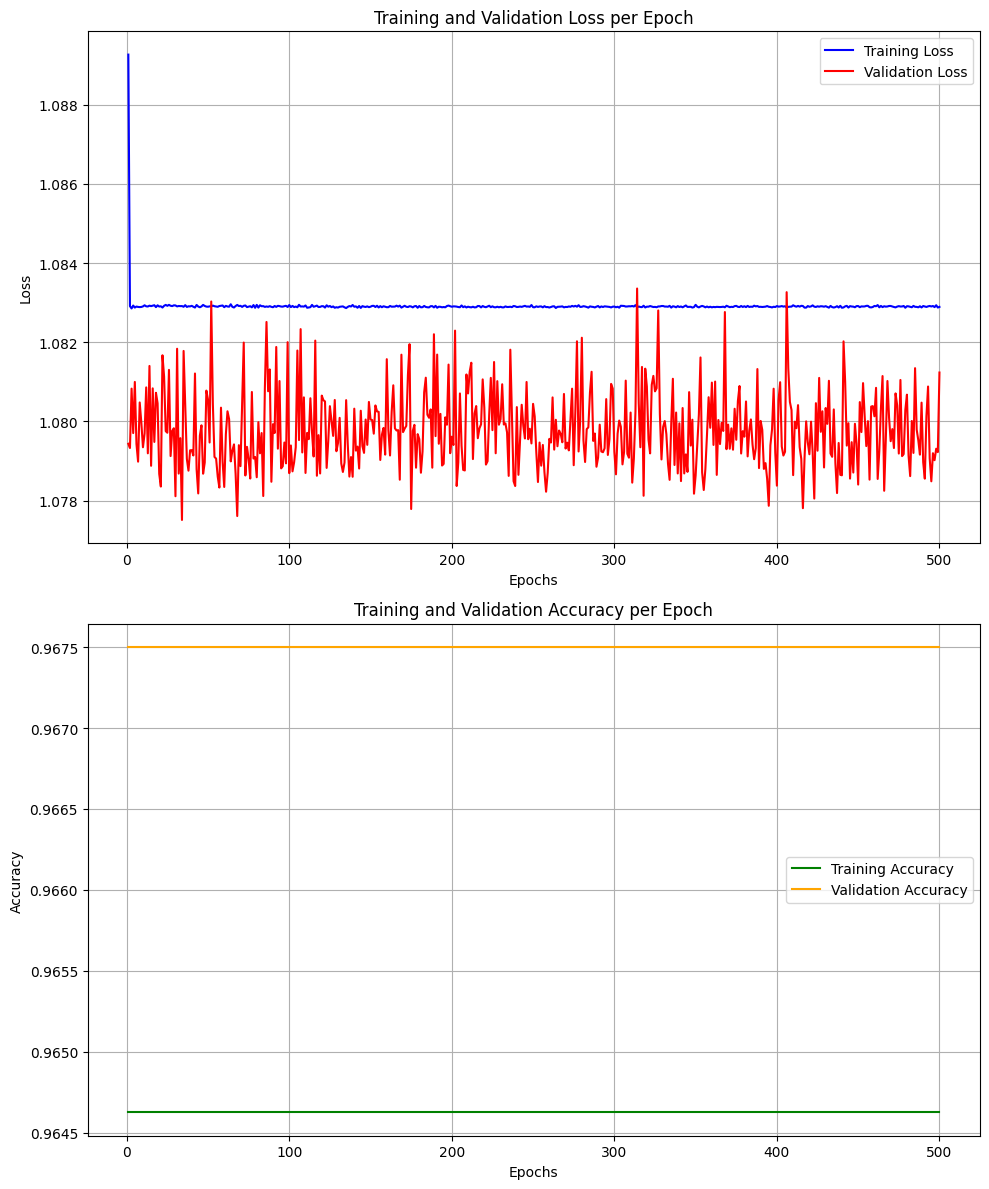

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from tqdm import tqdm

number_epochs = 500
learning_rate = 0.01
loss_per_epoch = []
loss_per_epoch_validation = []

import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm

def train_model1(train_dl, test_dl, model):
    # Paramètres
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=0.01, weight_decay=0.01)
    
    # Listes pour stocker la perte et l'accuracy à chaque époque
    loss_per_epoch = []
    loss_per_epoch_validation = []
    accuracy_per_epoch_train = []  # Liste pour stocker l'accuracy d'entraînement
    accuracy_per_epoch_valid = []  # Liste pour stocker l'accuracy de validation
    
    # Boucle d'entraînement
    for epoch in tqdm(range(500), desc="Training Epochs"):
        print(f"Epoch {epoch+1}\n-------------------------------")
        model.train()
        TrainingStep_loss = []

        for batch, (inputs, targets) in enumerate(train_dl):
            inputs = inputs.float()
            targets = targets.long()

            optimizer.zero_grad()
            yhat = model(inputs)
            loss = criterion(yhat, targets)
            loss.backward()
            optimizer.step()
            TrainingStep_loss.append(loss.item())

        train_loss = np.mean(TrainingStep_loss)
        loss_per_epoch.append(train_loss)
        print(f"Training Loss: {train_loss:.6f}")

        # Calculer l'accuracy d'entraînement
        train_accuracy = evaluate_model(train_dl, model)
        accuracy_per_epoch_train.append(train_accuracy)  # Stocker l'accuracy d'entraînement
        print(f"Training Accuracy: {train_accuracy:.6f}")

        # Validation
        model.eval()
        validationStep_loss = []

        with torch.no_grad():
            for batch, (inputs, targets) in enumerate(test_dl):
                inputs = inputs.float()
                targets = targets.long()
                outputs = model(inputs)
                validation_loss = criterion(outputs, targets)
                validationStep_loss.append(validation_loss.item())

        valid_loss = np.mean(validationStep_loss)
        loss_per_epoch_validation.append(valid_loss)
        print(f"Validation Loss: {valid_loss:.6f}")

        # Calculer l'accuracy de validation
        valid_accuracy = evaluate_model(test_dl, model)
        accuracy_per_epoch_valid.append(valid_accuracy)  # Stocker l'accuracy de validation
        print(f"Validation Accuracy: {valid_accuracy:.6f}")
        
    # Retourner les valeurs pour les tracer
    return loss_per_epoch, loss_per_epoch_validation, accuracy_per_epoch_train, accuracy_per_epoch_valid



# Après l'entraînement, tracer les courbes
def plot_loss_and_accuracy1(loss_train, loss_validation, acc_train, acc_validation):
    epochs = range(1, len(loss_train) + 1)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

    # Tracer la courbe de la perte
    ax1.plot(epochs, loss_train, label="Training Loss", color="b")
    ax1.plot(epochs, loss_validation, label="Validation Loss", color="r")
    ax1.set_title("Training and Validation Loss per Epoch")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend()
    ax1.grid(True)

    # Tracer la courbe de l'accuracy
    ax2.plot(epochs, acc_train, label="Training Accuracy", color="g")
    ax2.plot(epochs, acc_validation, label="Validation Accuracy", color="orange")
    ax2.set_title("Training and Validation Accuracy per Epoch")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()




# Exemple d'utilisation (préparez vos données et votre modèle avant d'utiliser ces fonctions)
train_dl, test_dl = prepare_data_sklearn(X, y)
model = MLP(7, 6)
loss_per_epoch, loss_per_epoch_validation, accuracy_per_epoch_train, accuracy_per_epoch_valid = train_model1(train_dl, test_dl, model)

# Tracer la perte et l'accuracy (vous devez passer aussi les listes d'accuracy)
plot_loss_and_accuracy1(loss_per_epoch, loss_per_epoch_validation, accuracy_per_epoch_train, accuracy_per_epoch_valid)



Trouver les meilleurs hyperparametre

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

param_grid = {
    'hidden_layer_sizes': [(64, 32), (128, 64), (256, 128)],  # Trois configurations de couches cachées
    'activation': ['relu', 'tanh', 'logistic'],  # Trois fonctions d'activation
    'solver': ['adam', 'sgd', 'lbfgs'],  # Trois optimisateurs
    'learning_rate_init': [0.001, 0.01, 0.1],  # Trois valeurs pour le taux d'apprentissage
    'max_iter': [200, 500, 1000]  # Trois valeurs pour le nombre d'itérations
}

# Initialiser le modèle MLPRegressor
mlp = MLPRegressor()

# Exécuter la recherche sur la grille avec validation croisée (cv=3)
grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, cv=3, n_jobs=-1)

# Ajuster le modèle sur les données d'entraînement
grid_search.fit(X_train, y_train)

# Afficher les meilleurs paramètres trouvés
print("Meilleurs paramètres : ", grid_search.best_params_)


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_op

Meilleurs paramètres :  {'activation': 'logistic', 'hidden_layer_sizes': (128, 64), 'learning_rate_init': 0.1, 'max_iter': 1000, 'solver': 'lbfgs'}


In [34]:
y.unique()

array([1, 3, 5, 2, 4, 0])

Epoch 1/1000


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1731679221.541831     137 service.cc:145] XLA service 0x7db0d0007fa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731679221.541882     137 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


114/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9271 - loss: 0.3233 

I0000 00:00:1731679222.357744     137 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9454 - loss: 0.2667 - val_accuracy: 0.9675 - val_loss: 0.1912
Epoch 2/1000
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9625 - loss: 0.2116 - val_accuracy: 0.9675 - val_loss: 0.1895
Epoch 3/1000
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9611 - loss: 0.2126 - val_accuracy: 0.9675 - val_loss: 0.1847
Epoch 4/1000
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9628 - loss: 0.1986 - val_accuracy: 0.9675 - val_loss: 0.1784
Epoch 5/1000
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9650 - loss: 0.1826 - val_accuracy: 0.9675 - val_loss: 0.1722
Epoch 6/1000
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9624 - loss: 0.1835 - val_accuracy: 0.9675 - val_loss: 0.1626
Epoch 7/1000
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9655 - loss: 0.1612 - val_accuracy: 0.9675 - val_loss: 0.1527
Epoch 8/1000
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9654 - loss: 0.1497 - val_accuracy:

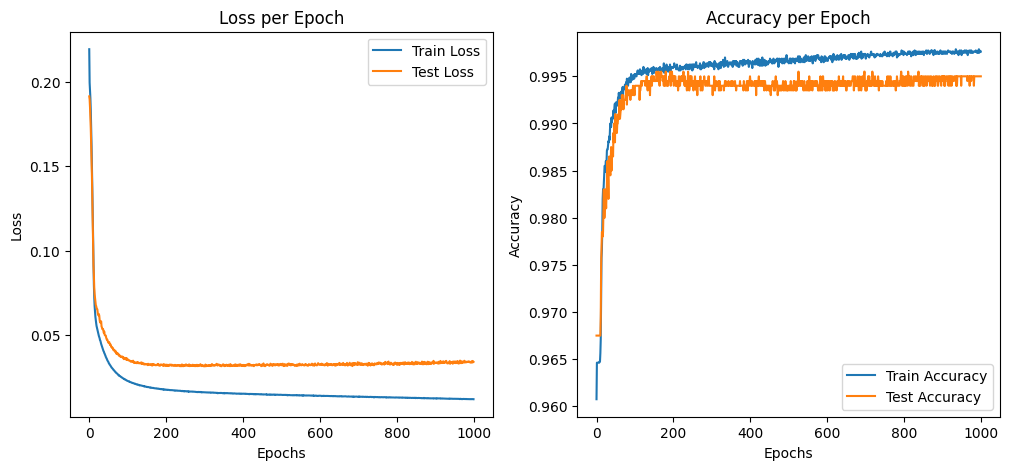

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification


y = to_categorical(y, num_classes=6)  # Convert labels to one-hot encoding

# 2. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Build the model with the best hyperparameters
model = Sequential()
model.add(Dense(128, input_dim=X.shape[1], activation='sigmoid'))  # First hidden layer (128 units)
model.add(Dense(64, activation='sigmoid'))  # Second hidden layer (64 units)
model.add(Dense(6, activation='softmax'))  # Output layer (3 classes)

# 4. Compile the model with appropriate parameters
model.compile(optimizer=SGD(learning_rate=0.1), loss='categorical_crossentropy', metrics=['accuracy'])

# 5. Train the model and store history
history = model.fit(X_train, y_train, epochs=1000, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# 6. Visualize the Loss and Accuracy
plt.figure(figsize=(12, 5))

# Loss Graph
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy Graph
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


**utiliser la methode de regularisation et dropout et refiare le calcul******

In [40]:
X = df1.drop('Failure Type', axis=1)  # Variables indépendantes
y = df1['Failure Type']  # Variable cible

Epoch 1/1000


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9465 - loss: 0.3777 - val_accuracy: 0.9675 - val_loss: 0.2849
Epoch 2/1000
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9638 - loss: 0.3101 - val_accuracy: 0.9675 - val_loss: 0.2731
Epoch 3/1000
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9661 - loss: 0.2842 - val_accuracy: 0.9675 - val_loss: 0.2644
Epoch 4/1000
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9619 - loss: 0.3006 - val_accuracy: 0.9675 - val_loss: 0.2565
Epoch 5/1000
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9614 - loss: 0.2910 - val_accuracy: 0.9675 - val_loss: 0.2495
Epoch 6/1000
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9634 - loss: 0.2734 - val_accuracy: 0.9675 - val_loss: 0.2440
Epoch 7/1000
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9651 - loss: 0.2599 - val_accuracy: 0.9675 - val_loss: 0.2396
Epoch 8/1000
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9630 - loss: 0.2654 - val_accuracy:

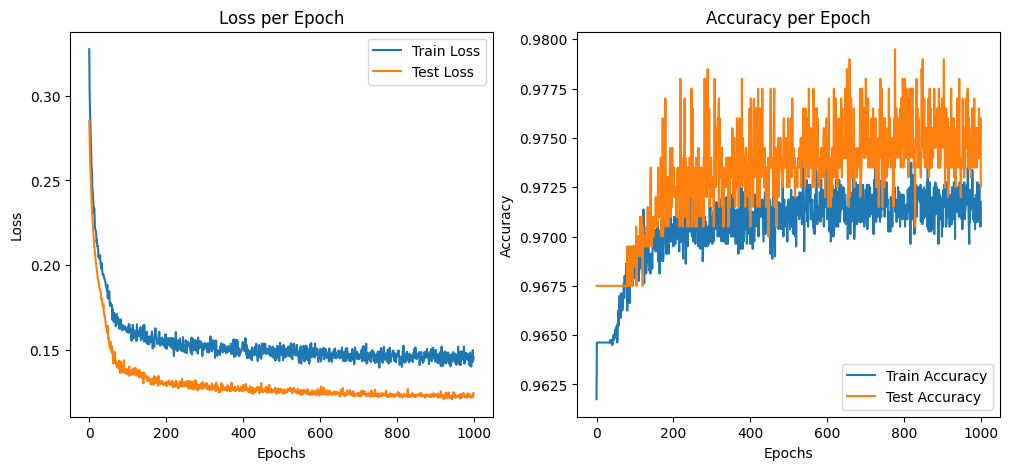

In [41]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.regularizers import l2
from keras.optimizers import SGD
from keras.utils import to_categorical


y = to_categorical(y, num_classes=6)  # Convert labels to one-hot encoding

# 2. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = Sequential()
model.add(Dense(128, input_dim=X.shape[1], activation='sigmoid',kernel_regularizer=l2(0.001)))  # First hidden layer (128 units)
model.add(Dropout(0.5))  # Apply Dropout with a probability of 50%

model.add(Dense(64, activation='sigmoid',kernel_regularizer=l2(0.001)))  # Second hidden layer (64 units)
model.add(Dropout(0.5))  # Dropout in the second layer

model.add(Dense(6, activation='softmax'))  # Output layer (3 classes)

# 4. Compile the model with appropriate parameters
model.compile(optimizer=SGD(learning_rate=0.1), loss='categorical_crossentropy', metrics=['accuracy'])

# 5. Train the model and store history
history = model.fit(X_train, y_train, epochs=1000, batch_size=32, validation_data=(X_test, y_test), verbose=1)





# Visualiser la perte et l'exactitude
plt.figure(figsize=(12, 5))

# Graphique de la perte
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Graphique de l'exactitude
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


Avant d'appliquer les techniques de régularisation, on constate que l'accuracy sur les données d'entraînement est nettement supérieure à celle des données de test. Cela indique un problème de surapprentissage (overfitting), où le modèle s'adapte trop spécifiquement aux données d'entraînement, au détriment de sa capacité à généraliser sur de nouvelles données. Pour remédier à ce problème, des techniques de régularisation telles que le Dropout et la régularisation L2 (ajoutée aux poids) sont mises en œuvre. Ces méthodes permettent de réduire l'overfitting en rendant le modèle plus robuste et en améliorant sa performance sur les données de test.